# Hyperparameter Optimization (Validation, Cross-Validation, Pipeline, and Grid Search)
___
## Setup
Let's use a simple dataset to review some of the ways we can optimize hyperparameters. The data on heart disease can be found [here](#https://www.kaggle.com/datasets/cherngs/heart-disease-cleveland-uci).

## Table of Contents

* [Data Dictionary](#data-dictionary)
* [Data Loading](#data-loading)
* [Optimization Using only One Validation Set](#optimization-using-only-one-validation-set)
* [Optimization Using Cross-Validation](#optimization-using-cross-validation)
* [Optimization Using Pipeline and Grid Search](#optimizing-using-pipeline-and-grid-search)
* [Conclusions and Common Questions](#conclusions-and-common-questions)


## Data Dictionary

| **Feature**  | **Description**                                                                                                                                                                                                                             |
|----------|-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Age      | age in years                                                                                                                                                                                                                            |
| Sex      | 1 = male; 0 = female                                                                                                                                                                                                                    |
| cp       | Chest pain type: 0 = typical angina, 1 = atypical angina, 2 = non-anginal pain, Value 3: asymptomatic                                                                                                                                   |
| trestbps | resting blood pressure (in mm Hg on admission to the hospital)                                                                                                                                                                          |
| chol     | serum cholestoral in mg/dl                                                                                                                                                                                                              |
| fbs      | fasting blood sugar > 120 mg/dl: 1 = true; 0 = false                                                                                                                                                                                    |
| restecg  | resting electrocardiographic results: 0 = normal, 1 = having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), 2 = showing probable or definite left ventricular hypertrophy by Estes' criteria |
| thalach  | maximum heart rate achieved                                                                                                                                                                                                             |
| exang    | exercise induced angina: 1 = yes; 0 = no                                                                                                                                                                                                |
| oldpeak  | ST depression induced by exercise relative to rest                                                                                                                                                                                      |
| slope    | the slope of the peak exercise ST segment: 0 = upsloping, 1 = flat, 2 = downsloping                                                                                                                                                     |
| ca       | number of major vessels (0-3) colored by flourosopy                                                                                                                                                                                     |
| thal     | 0 = normal; 1 = fixed defect; 2 = reversable defect and the label                                                                                                                                                                       |
                                                                                                                                                                        

| **Target**  | **Description**                                                                                                                                                                                                                             |
|----------|-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Condition      | 0 = no disease, 1 = disease

## Data Loading

In [1]:
# Basic packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# To split the data as necessary for modelling
from sklearn.model_selection import train_test_split

# To build a simple model
from sklearn.linear_model import LogisticRegression

# To get rid of logistic regression default solver warnings that appear if sklearn hasn't been updated
import warnings
warnings.filterwarnings('ignore')

# To "pickle" things, like accuracies or even an entire fitted model
import joblib

# To cross-validate
from sklearn.model_selection import cross_val_score

# To set up a temporary directory for caching pipeline results
from tempfile import mkdtemp

# To build a pipeline
from sklearn.pipeline import Pipeline

# To try scaling the data in various ways
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

# To try dimensionality reduction
from sklearn.decomposition import PCA

# To do a cross-validated grid search
from sklearn.model_selection import GridSearchCV

In [2]:
# Read the data into a dataframe
df = pd.read_csv('heart.csv')

# Take a look at the data
display(df)

# Any nulls?
print(f'There are {df.isna().sum().sum()} null values.')

# Any duplicates?
print(f'There are {df.duplicated().sum()} duplicate values.')

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,condition
0,69,1,0,160,234,1,2,131,0,0.1,1,1,0,0
1,69,0,0,140,239,0,0,151,0,1.8,0,2,0,0
2,66,0,0,150,226,0,0,114,0,2.6,2,0,0,0
3,65,1,0,138,282,1,2,174,0,1.4,1,1,0,1
4,64,1,0,110,211,0,2,144,1,1.8,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292,40,1,3,152,223,0,0,181,0,0.0,0,0,2,1
293,39,1,3,118,219,0,0,140,0,1.2,1,0,2,1
294,35,1,3,120,198,0,0,130,1,1.6,1,0,2,1
295,35,0,3,138,183,0,0,182,0,1.4,0,0,0,0


There are 0 null values.
There are 0 duplicate values.


In [3]:
# Check class counts
df['condition'].value_counts()

0    160
1    137
Name: condition, dtype: int64

In [4]:
# Check class proportions
df['condition'].value_counts(normalize=True)

0    0.538721
1    0.461279
Name: condition, dtype: float64

Things to note:
- The columns contain various health-related data.
- Each row corresponds to a patient.
- The target is either 1 (has heart disease) or 0 (does not have heart disease), so this will be a binary classification problem.
- The classes are fairly well-balanced. Ideally we'd do far more EDA, but we'll skip that for now.

In [5]:
# Set up X (i.e., independent variables; features) and y (i.e., dependent variable; target)
X = df.drop('condition', axis=1)
y = df['condition']

# Print shapes
print('Shape of X:', X.shape)
print('Shape of y:', y.shape)

Shape of X: (297, 13)
Shape of y: (297,)


___
## Optimization Using only One Validation Set
When we first learned about hyperparameter optimization, we used `train_test_split` twice. We first split the data into a remainder set and a test set, like so:

In [6]:
# Split the data into remainder and test sets
X_rem, X_test, y_rem, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

# Print info on how the data has been split
print(f'The remainder set has {len(X_rem)} data points.')
print(f'The test set has {len(X_test)} data points.')

The remainder set has 207 data points.
The test set has 90 data points.


Some things to note here:
- There is no test size that is perfect for any dataset; you'll have to consider how many data points you have in total and make a suitable decision. That being said, 0.3 is usually a safe choice.
- Why use the `random_state` parameter?
    - When using `train_test_split()`, the data points get shuffled by default and distributed randomly to the two resulting sets. Using the `random_state` parameter ensures we get reproducible results no matter where or how many times we run our cells.
    - This is found in many other Scikit-learn functions, and you'll see this parameter being used often.
    - You can pass in any integer; I usually just go with 1.
- Why use the `stratify` parameter?
    - We want the original class proportions (in `y`, in this case) to be preserved as closely as possible in each of the two resulting sets, and this parameter ensures that.
    - This is more important to use when dealing with imbalanced data. For an extremely imbalanced dataset, not using this parameter could result in the minority class not being included at all in one of the two sets.
    - This is just a safe choice for any classification task regardless of the class distribution you're dealing with.

Before we try to optimize hyperparameters using a validation set, let's try building a baseline model and see how it performs.

In [7]:
# Baseline logistic regression
# Instantiate and fit to the remainder set
baseline_logreg = LogisticRegression(random_state=1).fit(X_rem, y_rem)

# Print the accuracies
print(f'Accuracy on remainder set: {baseline_logreg.score(X_rem, y_rem)}')
print(f'Accuracy on test set: {baseline_logreg.score(X_test, y_test)}')

Accuracy on remainder set: 0.8695652173913043
Accuracy on test set: 0.8222222222222222


We'll keep these accuracies in mind for later.

We then set the test set aside and split the remainder set into a train set and a validation set, like so:

In [8]:
# Split the remainder set into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_rem, y_rem, test_size=0.2, random_state=1, stratify=y_rem)

# Print info on how the data has been split
print(f'The train set has {len(X_train)} data points.')
print(f'The validation set has {len(X_val)} data points.')

The train set has 165 data points.
The validation set has 42 data points.


More things to note:
- Again, there is no *ideal* size to use, but 0.2 seems appropriate. There is no need to make your test and validation sets the same size.
- This time we stratify according to `y_rem` instead of `y`.

We can check that the class proportions have been preserved in all sets.

In [9]:
print('Proportions in original data:')
print(y.value_counts(normalize=True), '\n')

print('Proportions in remainder set:')
print(y_rem.value_counts(normalize=True), '\n')

print('Proportions in test set:')
print(y_test.value_counts(normalize=True), '\n')

print('Proportions in train set:')
print(y_train.value_counts(normalize=True), '\n')

print('Proportions in validation set:')
print(y_val.value_counts(normalize=True), '\n')

Proportions in original data:
0    0.538721
1    0.461279
Name: condition, dtype: float64 

Proportions in remainder set:
0    0.541063
1    0.458937
Name: condition, dtype: float64 

Proportions in test set:
0    0.533333
1    0.466667
Name: condition, dtype: float64 

Proportions in train set:
0    0.539394
1    0.460606
Name: condition, dtype: float64 

Proportions in validation set:
0    0.547619
1    0.452381
Name: condition, dtype: float64 



It appears that the proportions have been preserved. Some of them could not be kept exactly the same just due to a limited availability of data points, but they are close enough.

At this point we could try fitting a scaler and/or PCA to the train set and then transforming the train and validation sets, but we'll skip that for now. Note that if we were to do this, we would have many different models to compare (grid search will come in handy for this later).

Let's try a simple hyperparameter optimization. We'll try varying the regularization strength (l2 in this case, since this is the default penalty for logistic regression in Scikit-learn).

### Manually Optimizing for C in Logistic Regression

In [10]:
# Let's try a modest range of C values
c_values = [.00001, .0001, .001, .01, .1, 1, 10, 100, 1000, 10000]

# Set up empty lists
train_accuracies = []
validation_accuracies = []

# Iterate over the C values
for value in c_values:
    
    # Instantiate a log reg and fit to the train set
    logreg = LogisticRegression(C=value, random_state=1).fit(X_train, y_train)
    
    # Score on the train set and append this accuracy to its respective list
    train_accuracies.append(logreg.score(X_train, y_train))
    
    # Score on the validation set and append this accuracy to its respective list
    validation_accuracies.append(logreg.score(X_val, y_val))

In [11]:
# Check the accuracies
pd.DataFrame({'C value': c_values, 'train accuracy': train_accuracies, 'validation accuracy': validation_accuracies})

,C value,train accuracy,validation accuracy
0,0.00001,0.672727,0.690476
1,0.00010,0.678788,0.785714
2,0.00100,0.709091,0.857143
3,0.01000,0.787879,0.857143
4,0.10000,0.854545,0.880952
5,1.00000,0.872727,0.880952
6,10.00000,0.872727,0.880952
7,100.00000,0.866667,0.857143
8,1000.00000,0.872727,0.880952
9,10000.00000,0.860606,0.857143


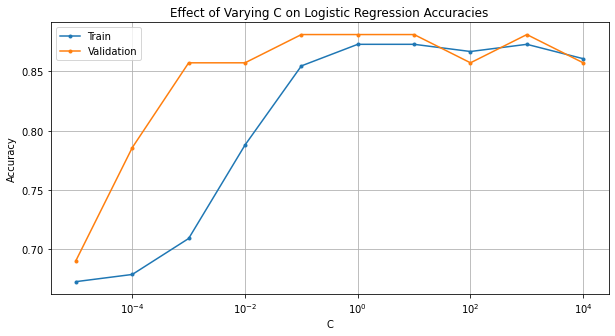

In [12]:
# Plot the accuracies
plt.figure(figsize=(10, 5))
plt.plot(c_values, train_accuracies, label='Train', marker='.')
plt.plot(c_values, validation_accuracies, label='Validation', marker='.')
plt.legend()
plt.title('Effect of Varying C on Logistic Regression Accuracies')
plt.xscale('log') # Put the x-axis on a log scale; this is important because the C values vary in orders of magnitude
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.grid()
plt.show()

We pick a value of C that yields the highest validation accuracy without the train accuracy being too high (which would indicate overfitting). Based on the above, let's choose a C value of 1000, build a final model, and score on the remainder and test sets. **Don't forget this step!**

In [13]:
# Instantiate a log reg and fit to the remainder set
validated_logreg = LogisticRegression(C=1000, random_state=1).fit(X_rem, y_rem)

# Print the accuracies
print(f'Accuracy on remainder set: {validated_logreg.score(X_rem, y_rem)}')
print(f'Accuracy on test set: {validated_logreg.score(X_test, y_test)}')

Accuracy on remainder set: 0.8647342995169082
Accuracy on test set: 0.8222222222222222


In [14]:
# Reminder: baseline accuracies from before
print(f'Accuracy on remainder set: {baseline_logreg.score(X_rem, y_rem)}')
print(f'Accuracy on test set: {baseline_logreg.score(X_test, y_test)}')

Accuracy on remainder set: 0.8695652173913043
Accuracy on test set: 0.8222222222222222


Note that the accuracies after doing one validation are actually lower than those of the baseline model (although pretty close). What happened? Isn't hyperparameter optimization supposed to lead to the best accuracies?

The best hyperparameter we found, which C = 1000, did result in the best *validation* accuracy. However, there was no guarantee that this would result in the best *test* accuracy.

Another thing to note: test accuracy is usually more important than remainder accuracy. After all, we want our models to perform well on *unseen* data.

In the hyperparameter optimization lecture, you then learned that the optimal hyperparameter we pick can vary depending on what data points were randomly included in the validation set, so the better option is to use cross-validation instead. So why would we ever do just one validation? This is because cross-validation is more computationally expensive than just validating once, and it's better to try validating at least once than not at all. If we were to pick an optimal hyperparameter using the test set, we would be peeking into data that the model was never supposed to see, hence *cheating*.

___
## Optimization Using Cross-Validation
Ideally we should always cross-validate when we want to optimize hyperparameters. When using cross-validation, we no longer need to split our data twice; that is, we can just pass in our remainder set, and the cross-validation function will automatically split the remainder set into train and validation sets in *k* different ways (_i.e._, folds).

The diagram below shows a 5-fold cross-validation. Each circle represents a data point, and the colours represent different classes. Notice that each data point (aside from those in the test set) gets to be in a validation set only once.

<img src = "https://scikit-learn.org/stable/_images/grid_search_cross_validation.png" width = 800>

When we do the single `train_test_split()` that is required for cross-validation (or for a grid search, as you'll see later), we no longer have to call our resulting sets the "remainder" and "test" sets. We can go back to calling them "train" and "test" sets if we want (and also name the variables accordingly), and then in cross-validation, the train set automatically gets split into *k* different *smaller* "train" and "validation" sets. This can get confusing, so if you still want to call them "remainder" and "test" sets, go ahead! Use whichever variable names that help your understanding. Note that in the pipeline lecture and for the preprocessed datasets that were sent out for NLP part 2, the sets were named "train" and "test".

With that said, let's now try 5-fold cross-validation. I will add some things that help us keep track of the progress, and explain them below.

In [15]:
%%time

# This is the same range of C values that I used before
c_values = [.00001, .0001, .001, .01, .1, 1, 10, 100, 1000, 10000]

# Set up an empty list
cv_accuracies = []

# Iterate over the C values
for value in c_values:
    
    # Instantiate a log reg
    logreg = LogisticRegression(C=value, random_state=1, n_jobs=-1)
    
    # Pass the model and the remainder set into the cross-validation function, then get cross-validated accuracy by taking the mean
    cv_accuracy = np.mean(cross_val_score(logreg, X_rem, y_rem, cv=5, n_jobs=-1))
    
    # Append the cross-validated accuracy to the list set up above
    cv_accuracies.append(cv_accuracy)
    
    # Dump the updated list of accuracies into a .pkl file
    joblib.dump(cv_accuracies, 'pickled_cv_accuracies.pkl')
    
    # Print something at the end of each iteration
    print(f'For a C value of {value}, the cross-validated accuracy is {round(cv_accuracy, 6)}')

For a C value of 1e-05, the cross-validated accuracy is 0.66144
For a C value of 0.0001, the cross-validated accuracy is 0.680604
For a C value of 0.001, the cross-validated accuracy is 0.709175
For a C value of 0.01, the cross-validated accuracy is 0.776771
For a C value of 0.1, the cross-validated accuracy is 0.834959
For a C value of 1, the cross-validated accuracy is 0.83043
For a C value of 10, the cross-validated accuracy is 0.835192
For a C value of 100, the cross-validated accuracy is 0.835192
For a C value of 1000, the cross-validated accuracy is 0.84007
For a C value of 10000, the cross-validated accuracy is 0.835308
Wall time: 2.55 s


Several things to note here:
- The `cross_val_score()` function checks if you are doing a classification task, and if so, uses `StratifiedKFold()` by default. Just like when I talked about `stratify` earlier, this ensures that class proportions are preserved in all the train and validation sets in the folds. You can read more about this in the documentation:
    - https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html
    - https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html
- The `cv` parameter refers to how many folds you want in your cross-validation. The default is 5 new version of Scikit-learn, but it was 3 in earlier versions. We manually set it to 5 here because we want five folds.
    - Like many other aspects of machine learning, the number of folds we choose is somewhat arbitrary. Five is conventional, and in each fold, 80% of the data is used for training and 20% is used for validation.
- The `cross_val_score` function returns 5 scores (or whatever number you set for `cv`). We then take the mean of these 5 scores, and this mean is what the cross-validated score actually is.

Keeping track of progress and speeding things up:
- Passing in `%%time` at the top of a cell will return how long it took for the whole cell to be run. Note that this has to be at the very top, and not even comments can be placed before it.
- Adding a simple print statement in the for loop is an easy way for us to keep track of the iterations.
- We can pass in `n_jobs=-1` to `LogisticRegression()` and `cross_val_score()` to use as many CPU cores as possible.
- We can pickle the accuracies using the joblib package. This way, even if the loop were to end prematurely for whatever reason, we can save some of the results and use them later.
- You can also try tweaking the `verbose` parameter in `cross_val_score()`. This parameter is also available in `GridSearchCV()`, which I'll showcase later.
- These things are more useful when working with a lot more data. They aren't necessary for the small dataset we're working with, but they're good to know! They can be done for one validation as well.

We can load in the pickled accuracies here or in any other notebook to work with.

In [16]:
# Load
pickled_cv_accuracies = joblib.load('pickled_cv_accuracies.pkl')

# Check
pickled_cv_accuracies

[0.6614401858304297,
 0.6806039488966318,
 0.7091753774680605,
 0.7767711962833913,
 0.8349593495934959,
 0.8304297328687571,
 0.8351916376306618,
 0.8351916376306618,
 0.8400696864111497,
 0.8353077816492449]

In [17]:
# Sanity check
cv_accuracies == pickled_cv_accuracies

True

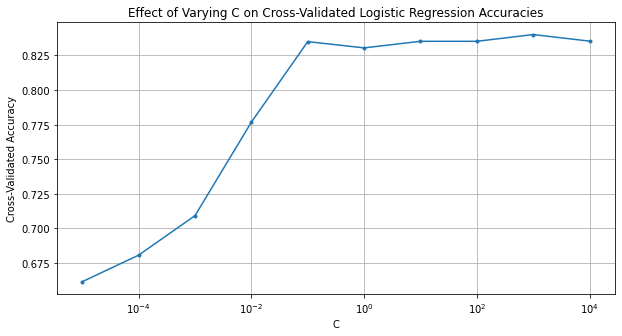

In [18]:
# Plot the accuracies
plt.figure(figsize=(10, 5))
plt.plot(c_values, cv_accuracies, marker = '.')
plt.title('Effect of Varying C on Cross-Validated Logistic Regression Accuracies')
plt.xscale('log') # Put the x-axis on a log scale; this is important because the C values vary in orders of magnitude
plt.xlabel('C')
plt.ylabel('Cross-Validated Accuracy')
plt.grid()
plt.show()

The downside of cross-validation is that we can't plot the train accuracies, but theoretically, cross-validation should combat overfitting.

Based on the above, let's choose a C value of 1000, build a final model, and score on the remainder and test sets. **Don't forget this step!**

In [19]:
# Instantiate a log reg and fit on the remainder set
cv_logreg = LogisticRegression(C=1000, random_state=1).fit(X_rem, y_rem)

# Print the accuracies
print(f'Accuracy on remainder set: {cv_logreg.score(X_rem, y_rem)}')
print(f'Accuracy on test set: {cv_logreg.score(X_test, y_test)}')

Accuracy on remainder set: 0.8647342995169082
Accuracy on test set: 0.8222222222222222


In [20]:
# Reminder: baseline accuracies from before
print(f'Accuracy on remainder set: {baseline_logreg.score(X_rem, y_rem)}')
print(f'Accuracy on test set: {baseline_logreg.score(X_test, y_test)}')

Accuracy on remainder set: 0.8695652173913043
Accuracy on test set: 0.8222222222222222


In [21]:
# Reminder: one-validation accuracies from before
print(f'Accuracy on remainder set: {validated_logreg.score(X_rem, y_rem)}')
print(f'Accuracy on test set: {validated_logreg.score(X_test, y_test)}')

Accuracy on remainder set: 0.8647342995169082
Accuracy on test set: 0.8222222222222222


- The test accuracy after using cross-validation is the same as the one from our baseline model, which once again shows that doing hyperparameter optimization doesn't guarantee we'll get better results, although it's still a good thing to do.
- When we used only one validation, the remainder accuracy was ~0.865 and the test accuracy was ~0.822, so we have done slightly better by using cross-validation.

Another downside of using cross-validation is that it becomes much harder to try scaling or PCA, since we would have to manually do so on each of the *k* folds (that's a lot of repetitive work). This is where pipeline and grid search come in handy.

___
## Optimizing Using Pipeline and Grid Search
Pipelines and grid searches take a lot of care to set up properly, but once they're set up, they allow us to do an exhaustive search over many different hyperparameters and evaluators.

In [22]:
# Set up a directory to cache the pipeline results
cachedir = mkdtemp()

# Set up a pipeline
# The steps here act as placeholders and will be changed when we pass the pipeline into the grid search later
my_pipeline = Pipeline([('scaler', StandardScaler()), ('dim_reducer', PCA()), ('model', LogisticRegression())], memory=cachedir)

Some things to note:
- We pass in the steps (_i.e._, the placeholder evaluators) as a list of tuples. Here we have a list of 3 tuples.
    - In each tuple, the first element is the name we give for the evaluator, and the second element is the evaluator itself.
- We can use the `memory` parameter to cache results. This helps speed up computation.

Now let's set up our parameter grid so we can try several estimators and hyperparameters:
- No scaler, standard scaler, min-max scaler, and robust scaler
- No PCA, and PCA with some different numbers of components
- Logistic regression with l1 and l2 regularizations (penalties), and with a range of regularization strengths (C values)

In [23]:
# Let's try the same range of C values from earlier
c_values = [.00001, .0001, .001, .01, .1, 1, 10, 100, 1000, 10000]

# Parameter grid
logreg_param_grid = [
    
    # l1 without PCA
    {'scaler': [None, StandardScaler(), MinMaxScaler(), RobustScaler()],
     'dim_reducer': [None],
     'model': [LogisticRegression(penalty='l1', random_state=1, n_jobs=-1)],
     'model__C': c_values},
    
    # l1 with PCA
    {'scaler': [StandardScaler(), MinMaxScaler(), RobustScaler()],
     'dim_reducer': [PCA()],
     'dim_reducer__n_components': [0.95, 0.9, 0.85, 0.8],
     'model': [LogisticRegression(penalty='l1', random_state=1, n_jobs=-1)],
     'model__C': c_values},
    
    # l2 (default) without PCA
    {'scaler': [None, StandardScaler(), MinMaxScaler(), RobustScaler()],
     'dim_reducer': [None],
     'model': [LogisticRegression(solver='lbfgs', random_state=1, n_jobs=-1)],
     'model__C': c_values},
    
    # l2 (default) with PCA
    {'scaler': [StandardScaler(), MinMaxScaler(), RobustScaler()],
     'dim_reducer': [PCA()],
     'dim_reducer__n_components': [0.95, 0.9, 0.85, 0.8],
     'model': [LogisticRegression(solver='lbfgs', random_state=1, n_jobs=-1)],
     'model__C': c_values}
]

Why didn't I do this?
```python
# Log reg
{'scaler': [StandardScaler(), MinMaxScaler(), RobustScaler()],
 'dim_reducer': [None, PCA()],
 'dim_reducer__n_components': [0.95, 0.9, 0.85, 0.8],
 'model': [LogisticRegression(random_state=1, n_jobs=-1)],
 'model__penalty': ['l1', 'l2'],
 'model__C': c_values}
```
- Trying various `n_components` isn't compatible with not using PCA.
- `lbfgs` isn't compatible with l1 penalty.

Several things to note:
- A parameter grid is a big list of dictionaries. Each dictionary can have several key-value pairs.
    - The keys are the evaluator names we set up in the pipeline object earlier, or the hyperparameters we want to tune. To refer to a hyperparameter, we have to type two underscores between the evaluator name and the hyperparameter. The syntax can be confusing and easy to mess up, so we have to pay close attention to get everything just right.
- I like to set up a parameter grid and grid search for each model type. For example, in my capstone, I had a setup for logistic regression, another for SVM, another for KNN, and so on. I find that this helps me keep track of how each type performs. If you make an enormous parameter grid with multiple model types, the grid search would take longer and it would be hard to tell which type is holding the entire search back.
- During the PCA lecture, we plotted `explained_variance_ratio_` to decide how many principal components to use. Although this was excellent for our understanding, a more convenient way when we tune this in a grid search is to pass in a float between 0 and 1 for the `n_components` parameter.
    - For example, if we pass in 0.95, the algorithm will automatically pick enough components to explain at least 95% of the variance.
- In Scikit-learn, the default penalty for logistic regression is l2.
    - `lbfgs` is a solver that is only available for l2 logistic regression. It is quicker for large datasets and is the default in newer versions of Scikit-learn.

We can now instantiate a cross-validated grid search and fit it to our remainder set. We can pass in our familiar `cv=5` for 5-fold cross-validation, and `n_jobs=-1` to use all CPU cores. There is also the `verbose` parameter that we can tweak to see some outputs on the progress.

This is what happens if we set `verbose` to 0 (default):

In [24]:
# Instantiate the log reg grid search
logreg_gs = GridSearchCV(my_pipeline, param_grid=logreg_param_grid, cv=5, n_jobs=-1, verbose=0)

# Fit the log reg grid search
fitted_logreg_gs = logreg_gs.fit(X_rem, y_rem)

___
This is what happens if we set `verbose` to 1:

In [25]:
# Instantiate the log reg grid search
logreg_gs = GridSearchCV(my_pipeline, param_grid=logreg_param_grid, cv=5, n_jobs=-1, verbose=1)

# Fit the log reg grid search
fitted_logreg_gs = logreg_gs.fit(X_rem, y_rem)

Fitting 5 folds for each of 320 candidates, totalling 1600 fits


___
This is what happens if we set `verbose` to 5:

In [26]:
# Instantiate the log reg grid search
logreg_gs = GridSearchCV(my_pipeline, param_grid=logreg_param_grid, cv=5, n_jobs=-1, verbose=5)

# Fit the log reg grid search
fitted_logreg_gs = logreg_gs.fit(X_rem, y_rem)

Fitting 5 folds for each of 320 candidates, totalling 1600 fits
[CV 1/5] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1e-05, scaler=None;, score=nan total time=   0.0s
[CV 2/5] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1e-05, scaler=None;, score=nan total time=   0.0s
[CV 3/5] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1e-05, scaler=None;, score=nan total time=   0.0s
[CV 4/5] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1e-05, scaler=None;, score=nan total time=   0.0s
[CV 5/5] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1e-05, scaler=None;, score=nan total time=   0.0s
[CV 1/5] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1e-05, scaler=StandardScaler();, score=nan t

[CV 2/5] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.01, scaler=StandardScaler();, score=nan total time=   0.0s
[CV 3/5] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.01, scaler=StandardScaler();, score=nan total time=   0.0s
[CV 4/5] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.01, scaler=StandardScaler();, score=nan total time=   0.0s
[CV 5/5] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.01, scaler=StandardScaler();, score=nan total time=   0.0s
[CV 1/5] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.01, scaler=MinMaxScaler();, score=nan total time=   0.0s
[CV 2/5] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.01, scaler=MinMaxScaler();, score=nan total time=   0

[CV 4/5] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=10, scaler=RobustScaler();, score=nan total time=   0.0s
[CV 5/5] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=10, scaler=RobustScaler();, score=nan total time=   0.0s
[CV 1/5] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=100, scaler=None;, score=nan total time=   0.0s
[CV 2/5] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=100, scaler=None;, score=nan total time=   0.0s
[CV 3/5] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=100, scaler=None;, score=nan total time=   0.0s
[CV 4/5] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=100, scaler=None;, score=nan total time=   0.0s
[CV 5/5] END dim_reducer=None, model=LogisticRegress

[CV 1/5] END dim_reducer=PCA(), dim_reducer__n_components=0.95, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1e-05, scaler=MinMaxScaler();, score=nan total time=   0.0s
[CV 2/5] END dim_reducer=PCA(), dim_reducer__n_components=0.95, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1e-05, scaler=MinMaxScaler();, score=nan total time=   0.0s
[CV 3/5] END dim_reducer=PCA(), dim_reducer__n_components=0.95, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1e-05, scaler=MinMaxScaler();, score=nan total time=   0.0s
[CV 4/5] END dim_reducer=PCA(), dim_reducer__n_components=0.95, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1e-05, scaler=MinMaxScaler();, score=nan total time=   0.0s
[CV 5/5] END dim_reducer=PCA(), dim_reducer__n_components=0.95, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1e-05, scaler=MinMaxScaler();, score=nan total time=   0.0s


[CV 3/5] END dim_reducer=PCA(), dim_reducer__n_components=0.95, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.01, scaler=MinMaxScaler();, score=nan total time=   0.0s
[CV 4/5] END dim_reducer=PCA(), dim_reducer__n_components=0.95, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.01, scaler=MinMaxScaler();, score=nan total time=   0.0s
[CV 5/5] END dim_reducer=PCA(), dim_reducer__n_components=0.95, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.01, scaler=MinMaxScaler();, score=nan total time=   0.0s
[CV 1/5] END dim_reducer=PCA(), dim_reducer__n_components=0.95, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.01, scaler=RobustScaler();, score=nan total time=   0.0s
[CV 2/5] END dim_reducer=PCA(), dim_reducer__n_components=0.95, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.01, scaler=RobustScaler();, score=nan total time=   0.0s
[CV 3

[CV 4/5] END dim_reducer=PCA(), dim_reducer__n_components=0.95, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=10, scaler=MinMaxScaler();, score=nan total time=   0.0s
[CV 5/5] END dim_reducer=PCA(), dim_reducer__n_components=0.95, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=10, scaler=MinMaxScaler();, score=nan total time=   0.0s
[CV 1/5] END dim_reducer=PCA(), dim_reducer__n_components=0.95, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=10, scaler=RobustScaler();, score=nan total time=   0.0s
[CV 2/5] END dim_reducer=PCA(), dim_reducer__n_components=0.95, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=10, scaler=RobustScaler();, score=nan total time=   0.0s
[CV 3/5] END dim_reducer=PCA(), dim_reducer__n_components=0.95, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=10, scaler=RobustScaler();, score=nan total time=   0.0s
[CV 4/5] END di

[CV 2/5] END dim_reducer=PCA(), dim_reducer__n_components=0.95, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=10000, scaler=RobustScaler();, score=nan total time=   0.0s
[CV 3/5] END dim_reducer=PCA(), dim_reducer__n_components=0.95, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=10000, scaler=RobustScaler();, score=nan total time=   0.0s
[CV 4/5] END dim_reducer=PCA(), dim_reducer__n_components=0.95, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=10000, scaler=RobustScaler();, score=nan total time=   0.0s
[CV 5/5] END dim_reducer=PCA(), dim_reducer__n_components=0.95, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=10000, scaler=RobustScaler();, score=nan total time=   0.0s
[CV 1/5] END dim_reducer=PCA(), dim_reducer__n_components=0.9, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1e-05, scaler=StandardScaler();, score=nan total time=   0.0s

[CV 4/5] END dim_reducer=PCA(), dim_reducer__n_components=0.9, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.001, scaler=MinMaxScaler();, score=nan total time=   0.0s
[CV 5/5] END dim_reducer=PCA(), dim_reducer__n_components=0.9, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.001, scaler=MinMaxScaler();, score=nan total time=   0.0s
[CV 1/5] END dim_reducer=PCA(), dim_reducer__n_components=0.9, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.001, scaler=RobustScaler();, score=nan total time=   0.0s
[CV 2/5] END dim_reducer=PCA(), dim_reducer__n_components=0.9, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.001, scaler=RobustScaler();, score=nan total time=   0.0s
[CV 3/5] END dim_reducer=PCA(), dim_reducer__n_components=0.9, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.001, scaler=RobustScaler();, score=nan total time=   0.0s
[CV 4

[CV 3/5] END dim_reducer=PCA(), dim_reducer__n_components=0.9, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1, scaler=MinMaxScaler();, score=nan total time=   0.0s
[CV 4/5] END dim_reducer=PCA(), dim_reducer__n_components=0.9, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1, scaler=MinMaxScaler();, score=nan total time=   0.0s
[CV 5/5] END dim_reducer=PCA(), dim_reducer__n_components=0.9, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1, scaler=MinMaxScaler();, score=nan total time=   0.0s
[CV 1/5] END dim_reducer=PCA(), dim_reducer__n_components=0.9, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1, scaler=RobustScaler();, score=nan total time=   0.0s
[CV 2/5] END dim_reducer=PCA(), dim_reducer__n_components=0.9, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1, scaler=RobustScaler();, score=nan total time=   0.0s
[CV 3/5] END dim_reducer=

[CV 5/5] END dim_reducer=PCA(), dim_reducer__n_components=0.9, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1000, scaler=StandardScaler();, score=nan total time=   0.0s
[CV 1/5] END dim_reducer=PCA(), dim_reducer__n_components=0.9, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1000, scaler=MinMaxScaler();, score=nan total time=   0.0s
[CV 2/5] END dim_reducer=PCA(), dim_reducer__n_components=0.9, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1000, scaler=MinMaxScaler();, score=nan total time=   0.0s
[CV 3/5] END dim_reducer=PCA(), dim_reducer__n_components=0.9, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1000, scaler=MinMaxScaler();, score=nan total time=   0.0s
[CV 4/5] END dim_reducer=PCA(), dim_reducer__n_components=0.9, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1000, scaler=MinMaxScaler();, score=nan total time=   0.0s
[CV 5/5]

[CV 5/5] END dim_reducer=PCA(), dim_reducer__n_components=0.85, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.0001, scaler=StandardScaler();, score=nan total time=   0.0s
[CV 1/5] END dim_reducer=PCA(), dim_reducer__n_components=0.85, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.0001, scaler=MinMaxScaler();, score=nan total time=   0.0s
[CV 2/5] END dim_reducer=PCA(), dim_reducer__n_components=0.85, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.0001, scaler=MinMaxScaler();, score=nan total time=   0.0s
[CV 3/5] END dim_reducer=PCA(), dim_reducer__n_components=0.85, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.0001, scaler=MinMaxScaler();, score=nan total time=   0.0s
[CV 4/5] END dim_reducer=PCA(), dim_reducer__n_components=0.85, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.0001, scaler=MinMaxScaler();, score=nan total time= 

[CV 4/5] END dim_reducer=PCA(), dim_reducer__n_components=0.85, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.1, scaler=MinMaxScaler();, score=nan total time=   0.0s
[CV 5/5] END dim_reducer=PCA(), dim_reducer__n_components=0.85, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.1, scaler=MinMaxScaler();, score=nan total time=   0.0s
[CV 1/5] END dim_reducer=PCA(), dim_reducer__n_components=0.85, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.1, scaler=RobustScaler();, score=nan total time=   0.0s
[CV 2/5] END dim_reducer=PCA(), dim_reducer__n_components=0.85, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.1, scaler=RobustScaler();, score=nan total time=   0.0s
[CV 3/5] END dim_reducer=PCA(), dim_reducer__n_components=0.85, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.1, scaler=RobustScaler();, score=nan total time=   0.0s
[CV 4/5] E

[CV 4/5] END dim_reducer=PCA(), dim_reducer__n_components=0.85, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=100, scaler=MinMaxScaler();, score=nan total time=   0.0s
[CV 5/5] END dim_reducer=PCA(), dim_reducer__n_components=0.85, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=100, scaler=MinMaxScaler();, score=nan total time=   0.0s
[CV 1/5] END dim_reducer=PCA(), dim_reducer__n_components=0.85, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=100, scaler=RobustScaler();, score=nan total time=   0.0s
[CV 2/5] END dim_reducer=PCA(), dim_reducer__n_components=0.85, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=100, scaler=RobustScaler();, score=nan total time=   0.0s
[CV 3/5] END dim_reducer=PCA(), dim_reducer__n_components=0.85, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=100, scaler=RobustScaler();, score=nan total time=   0.0s
[CV 4/5] E

[CV 2/5] END dim_reducer=PCA(), dim_reducer__n_components=0.8, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1e-05, scaler=MinMaxScaler();, score=nan total time=   0.0s
[CV 3/5] END dim_reducer=PCA(), dim_reducer__n_components=0.8, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1e-05, scaler=MinMaxScaler();, score=nan total time=   0.0s
[CV 4/5] END dim_reducer=PCA(), dim_reducer__n_components=0.8, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1e-05, scaler=MinMaxScaler();, score=nan total time=   0.0s
[CV 5/5] END dim_reducer=PCA(), dim_reducer__n_components=0.8, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1e-05, scaler=MinMaxScaler();, score=nan total time=   0.0s
[CV 1/5] END dim_reducer=PCA(), dim_reducer__n_components=0.8, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1e-05, scaler=RobustScaler();, score=nan total time=   0.0s
[CV 2

[CV 5/5] END dim_reducer=PCA(), dim_reducer__n_components=0.8, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.01, scaler=RobustScaler();, score=nan total time=   0.0s
[CV 1/5] END dim_reducer=PCA(), dim_reducer__n_components=0.8, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.1, scaler=StandardScaler();, score=nan total time=   0.0s
[CV 2/5] END dim_reducer=PCA(), dim_reducer__n_components=0.8, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.1, scaler=StandardScaler();, score=nan total time=   0.0s
[CV 3/5] END dim_reducer=PCA(), dim_reducer__n_components=0.8, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.1, scaler=StandardScaler();, score=nan total time=   0.0s
[CV 4/5] END dim_reducer=PCA(), dim_reducer__n_components=0.8, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.1, scaler=StandardScaler();, score=nan total time=   0.0s
[CV 5/

[CV 3/5] END dim_reducer=PCA(), dim_reducer__n_components=0.8, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=100, scaler=StandardScaler();, score=nan total time=   0.0s
[CV 4/5] END dim_reducer=PCA(), dim_reducer__n_components=0.8, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=100, scaler=StandardScaler();, score=nan total time=   0.0s
[CV 5/5] END dim_reducer=PCA(), dim_reducer__n_components=0.8, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=100, scaler=StandardScaler();, score=nan total time=   0.0s
[CV 1/5] END dim_reducer=PCA(), dim_reducer__n_components=0.8, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=100, scaler=MinMaxScaler();, score=nan total time=   0.0s
[CV 2/5] END dim_reducer=PCA(), dim_reducer__n_components=0.8, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=100, scaler=MinMaxScaler();, score=nan total time=   0.0s
[CV 3/5] 

[CV 2/5] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=1e-05, scaler=None;, score=0.714 total time=   0.0s
[CV 3/5] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=1e-05, scaler=None;, score=0.659 total time=   0.0s
[CV 4/5] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=1e-05, scaler=None;, score=0.634 total time=   0.0s
[CV 5/5] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=1e-05, scaler=None;, score=0.610 total time=   0.0s
[CV 1/5] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=1e-05, scaler=StandardScaler();, score=0.548 total time=   0.0s
[CV 2/5] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=1e-05, scaler=StandardScaler();, score=0.548 total time=   0.0s
[CV 3/5] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=1e-05, scaler

[CV 5/5] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=0.001, scaler=RobustScaler();, score=0.610 total time=   0.0s
[CV 1/5] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=0.01, scaler=None;, score=0.810 total time=   0.0s
[CV 2/5] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=0.01, scaler=None;, score=0.952 total time=   0.0s
[CV 3/5] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=0.01, scaler=None;, score=0.805 total time=   0.0s
[CV 4/5] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=0.01, scaler=None;, score=0.756 total time=   0.0s
[CV 5/5] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=0.01, scaler=None;, score=0.561 total time=   0.0s
[CV 1/5] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=0.01, scaler=StandardScaler();, 

[CV 2/5] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=10, scaler=None;, score=0.976 total time=   0.0s
[CV 3/5] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=10, scaler=None;, score=0.805 total time=   0.0s
[CV 4/5] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=10, scaler=None;, score=0.805 total time=   0.0s
[CV 5/5] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=10, scaler=None;, score=0.780 total time=   0.0s
[CV 1/5] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=10, scaler=StandardScaler();, score=0.786 total time=   0.0s
[CV 2/5] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=10, scaler=StandardScaler();, score=0.929 total time=   0.0s
[CV 3/5] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=10, scaler=StandardScaler();, s

[CV 4/5] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=10000, scaler=None;, score=0.805 total time=   0.0s
[CV 5/5] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=10000, scaler=None;, score=0.805 total time=   0.0s
[CV 1/5] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=10000, scaler=StandardScaler();, score=0.786 total time=   0.0s
[CV 2/5] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=10000, scaler=StandardScaler();, score=0.929 total time=   0.0s
[CV 3/5] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=10000, scaler=StandardScaler();, score=0.805 total time=   0.0s
[CV 4/5] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=10000, scaler=StandardScaler();, score=0.805 total time=   0.0s
[CV 5/5] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1)

[CV 1/5] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.95, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.001, scaler=StandardScaler();, score=0.690 total time=   0.0s
[CV 2/5] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.95, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.001, scaler=StandardScaler();, score=0.810 total time=   0.0s
[CV 3/5] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.95, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.001, scaler=StandardScaler();, score=0.756 total time=   0.0s
[CV 4/5] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.95, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.001, scaler=StandardScaler();, score=0.659 total time=   0.0s
[CV 5/5] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.95, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), mod

[CV 5/5] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.95, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.1, scaler=MinMaxScaler();, score=0.780 total time=   0.0s
[CV 1/5] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.95, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.1, scaler=RobustScaler();, score=0.833 total time=   0.0s
[CV 2/5] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.95, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.1, scaler=RobustScaler();, score=0.952 total time=   0.0s
[CV 3/5] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.95, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.1, scaler=RobustScaler();, score=0.878 total time=   0.0s
[CV 4/5] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.95, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.1, scale

[CV 4/5] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.95, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=100, scaler=MinMaxScaler();, score=0.780 total time=   0.0s
[CV 5/5] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.95, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=100, scaler=MinMaxScaler();, score=0.732 total time=   0.0s
[CV 1/5] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.95, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=100, scaler=RobustScaler();, score=0.738 total time=   0.0s
[CV 2/5] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.95, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=100, scaler=RobustScaler();, score=0.929 total time=   0.0s
[CV 3/5] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.95, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=100, scale

[CV 5/5] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.9, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=1e-05, scaler=MinMaxScaler();, score=0.537 total time=   0.0s
[CV 1/5] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.9, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=1e-05, scaler=RobustScaler();, score=0.548 total time=   0.0s
[CV 2/5] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.9, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=1e-05, scaler=RobustScaler();, score=0.548 total time=   0.0s
[CV 3/5] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.9, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=1e-05, scaler=RobustScaler();, score=0.537 total time=   0.0s
[CV 4/5] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.9, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=1e-05, 

[CV 2/5] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.9, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.01, scaler=RobustScaler();, score=0.952 total time=   0.0s
[CV 3/5] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.9, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.01, scaler=RobustScaler();, score=0.902 total time=   0.0s
[CV 4/5] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.9, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.01, scaler=RobustScaler();, score=0.829 total time=   0.0s
[CV 5/5] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.9, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.01, scaler=RobustScaler();, score=0.732 total time=   0.0s
[CV 1/5] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.9, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.1, scaler

[CV 5/5] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.9, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=10, scaler=RobustScaler();, score=0.756 total time=   0.0s
[CV 1/5] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.9, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=100, scaler=StandardScaler();, score=0.810 total time=   0.0s
[CV 2/5] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.9, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=100, scaler=StandardScaler();, score=0.905 total time=   0.0s
[CV 3/5] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.9, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=100, scaler=StandardScaler();, score=0.854 total time=   0.0s
[CV 4/5] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.9, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=100, scale

[CV 3/5] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.9, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=10000, scaler=RobustScaler();, score=0.829 total time=   0.0s
[CV 4/5] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.9, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=10000, scaler=RobustScaler();, score=0.829 total time=   0.0s
[CV 5/5] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.9, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=10000, scaler=RobustScaler();, score=0.756 total time=   0.0s
[CV 1/5] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.85, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=1e-05, scaler=StandardScaler();, score=0.548 total time=   0.0s
[CV 2/5] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.85, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=1e-

[CV 3/5] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.85, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.001, scaler=RobustScaler();, score=0.537 total time=   0.0s
[CV 4/5] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.85, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.001, scaler=RobustScaler();, score=0.585 total time=   0.0s
[CV 5/5] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.85, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.001, scaler=RobustScaler();, score=0.610 total time=   0.0s
[CV 1/5] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.85, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.01, scaler=StandardScaler();, score=0.905 total time=   0.0s
[CV 2/5] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.85, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0

[CV 2/5] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.85, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=1, scaler=RobustScaler();, score=0.952 total time=   0.0s
[CV 3/5] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.85, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=1, scaler=RobustScaler();, score=0.829 total time=   0.0s
[CV 4/5] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.85, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=1, scaler=RobustScaler();, score=0.805 total time=   0.0s
[CV 5/5] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.85, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=1, scaler=RobustScaler();, score=0.756 total time=   0.0s
[CV 1/5] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.85, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=10, scaler=Standar

[CV 3/5] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.85, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=1000, scaler=RobustScaler();, score=0.829 total time=   0.0s
[CV 4/5] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.85, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=1000, scaler=RobustScaler();, score=0.805 total time=   0.0s
[CV 5/5] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.85, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=1000, scaler=RobustScaler();, score=0.756 total time=   0.0s
[CV 1/5] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.85, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=10000, scaler=StandardScaler();, score=0.833 total time=   0.0s
[CV 2/5] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.85, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=100

[CV 5/5] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.8, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.0001, scaler=MinMaxScaler();, score=0.537 total time=   0.0s
[CV 1/5] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.8, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.0001, scaler=RobustScaler();, score=0.548 total time=   0.0s
[CV 2/5] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.8, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.0001, scaler=RobustScaler();, score=0.548 total time=   0.0s
[CV 3/5] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.8, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.0001, scaler=RobustScaler();, score=0.537 total time=   0.0s
[CV 4/5] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.8, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.0

[CV 2/5] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.8, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.1, scaler=RobustScaler();, score=0.952 total time=   0.0s
[CV 3/5] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.8, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.1, scaler=RobustScaler();, score=0.878 total time=   0.0s
[CV 4/5] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.8, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.1, scaler=RobustScaler();, score=0.805 total time=   0.0s
[CV 5/5] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.8, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.1, scaler=RobustScaler();, score=0.732 total time=   0.0s
[CV 1/5] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.8, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=1, scaler=Stand

[CV 1/5] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.8, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=100, scaler=RobustScaler();, score=0.833 total time=   0.0s
[CV 2/5] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.8, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=100, scaler=RobustScaler();, score=0.952 total time=   0.0s
[CV 3/5] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.8, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=100, scaler=RobustScaler();, score=0.829 total time=   0.0s
[CV 4/5] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.8, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=100, scaler=RobustScaler();, score=0.805 total time=   0.0s
[CV 5/5] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.8, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=100, scaler=Rob

___
This is what happens if we set `verbose` to 10:

In [27]:
# Instantiate the log reg grid search
logreg_gs = GridSearchCV(my_pipeline, param_grid=logreg_param_grid, cv=5, n_jobs=-1, verbose=10)

# Fit the log reg grid search (this is what takes long)
fitted_logreg_gs = logreg_gs.fit(X_rem, y_rem)

Fitting 5 folds for each of 320 candidates, totalling 1600 fits
[CV 1/5; 1/320] START dim_reducer=None, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1e-05, scaler=None
[CV 1/5; 1/320] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1e-05, scaler=None;, score=nan total time=   0.0s
[CV 2/5; 1/320] START dim_reducer=None, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1e-05, scaler=None
[CV 2/5; 1/320] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1e-05, scaler=None;, score=nan total time=   0.0s
[CV 3/5; 1/320] START dim_reducer=None, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1e-05, scaler=None
[CV 3/5; 1/320] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1e-05, scaler=None;, score=nan total time=   0.0s
[CV 4/5; 1/320] START dim_reducer=None,

[CV 1/5; 10/320] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.001, scaler=StandardScaler();, score=nan total time=   0.0s
[CV 2/5; 10/320] START dim_reducer=None, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.001, scaler=StandardScaler()
[CV 2/5; 10/320] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.001, scaler=StandardScaler();, score=nan total time=   0.0s
[CV 3/5; 10/320] START dim_reducer=None, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.001, scaler=StandardScaler()
[CV 3/5; 10/320] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.001, scaler=StandardScaler();, score=nan total time=   0.0s
[CV 4/5; 10/320] START dim_reducer=None, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.001, scaler=StandardScaler()
[CV 4/5; 10/320] END dim_

[CV 4/5; 15/320] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.01, scaler=MinMaxScaler();, score=nan total time=   0.0s
[CV 5/5; 15/320] START dim_reducer=None, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.01, scaler=MinMaxScaler()
[CV 5/5; 15/320] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.01, scaler=MinMaxScaler();, score=nan total time=   0.0s
[CV 1/5; 16/320] START dim_reducer=None, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.01, scaler=RobustScaler()
[CV 1/5; 16/320] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.01, scaler=RobustScaler();, score=nan total time=   0.0s
[CV 2/5; 16/320] START dim_reducer=None, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.01, scaler=RobustScaler()
[CV 2/5; 16/320] END dim_reducer=None, mode

[CV 4/5; 23/320] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1, scaler=MinMaxScaler();, score=nan total time=   0.0s
[CV 5/5; 23/320] START dim_reducer=None, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1, scaler=MinMaxScaler()
[CV 5/5; 23/320] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1, scaler=MinMaxScaler();, score=nan total time=   0.0s
[CV 1/5; 24/320] START dim_reducer=None, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1, scaler=RobustScaler()
[CV 1/5; 24/320] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1, scaler=RobustScaler();, score=nan total time=   0.0s
[CV 2/5; 24/320] START dim_reducer=None, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1, scaler=RobustScaler()
[CV 2/5; 24/320] END dim_reducer=None, model=LogisticRegressi

[CV 3/5; 32/320] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=100, scaler=RobustScaler();, score=nan total time=   0.0s
[CV 4/5; 32/320] START dim_reducer=None, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=100, scaler=RobustScaler()
[CV 4/5; 32/320] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=100, scaler=RobustScaler();, score=nan total time=   0.0s
[CV 5/5; 32/320] START dim_reducer=None, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=100, scaler=RobustScaler()
[CV 5/5; 32/320] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=100, scaler=RobustScaler();, score=nan total time=   0.0s
[CV 1/5; 33/320] START dim_reducer=None, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1000, scaler=None
[CV 1/5; 33/320] END dim_reducer=None, model=LogisticRegre

[CV 3/5; 40/320] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=10000, scaler=RobustScaler();, score=nan total time=   0.0s
[CV 4/5; 40/320] START dim_reducer=None, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=10000, scaler=RobustScaler()
[CV 4/5; 40/320] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=10000, scaler=RobustScaler();, score=nan total time=   0.0s
[CV 5/5; 40/320] START dim_reducer=None, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=10000, scaler=RobustScaler()
[CV 5/5; 40/320] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=10000, scaler=RobustScaler();, score=nan total time=   0.0s
[CV 1/5; 41/320] START dim_reducer=PCA(), dim_reducer__n_components=0.95, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1e-05, scaler=StandardScaler()
[C

[CV 4/5; 46/320] END dim_reducer=PCA(), dim_reducer__n_components=0.95, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.0001, scaler=RobustScaler();, score=nan total time=   0.0s
[CV 5/5; 46/320] START dim_reducer=PCA(), dim_reducer__n_components=0.95, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.0001, scaler=RobustScaler()
[CV 5/5; 46/320] END dim_reducer=PCA(), dim_reducer__n_components=0.95, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.0001, scaler=RobustScaler();, score=nan total time=   0.0s
[CV 1/5; 47/320] START dim_reducer=PCA(), dim_reducer__n_components=0.95, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.001, scaler=StandardScaler()
[CV 1/5; 47/320] END dim_reducer=PCA(), dim_reducer__n_components=0.95, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.001, scaler=StandardScaler();, score=nan total time=   0.0s
[CV 2/5; 47

[CV 4/5; 52/320] END dim_reducer=PCA(), dim_reducer__n_components=0.95, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.01, scaler=RobustScaler();, score=nan total time=   0.0s
[CV 5/5; 52/320] START dim_reducer=PCA(), dim_reducer__n_components=0.95, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.01, scaler=RobustScaler()
[CV 5/5; 52/320] END dim_reducer=PCA(), dim_reducer__n_components=0.95, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.01, scaler=RobustScaler();, score=nan total time=   0.0s
[CV 1/5; 53/320] START dim_reducer=PCA(), dim_reducer__n_components=0.95, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.1, scaler=StandardScaler()
[CV 1/5; 53/320] END dim_reducer=PCA(), dim_reducer__n_components=0.95, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.1, scaler=StandardScaler();, score=nan total time=   0.0s
[CV 2/5; 53/320] STAR

[CV 3/5; 58/320] END dim_reducer=PCA(), dim_reducer__n_components=0.95, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1, scaler=RobustScaler();, score=nan total time=   0.0s
[CV 4/5; 58/320] START dim_reducer=PCA(), dim_reducer__n_components=0.95, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1, scaler=RobustScaler()
[CV 4/5; 58/320] END dim_reducer=PCA(), dim_reducer__n_components=0.95, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1, scaler=RobustScaler();, score=nan total time=   0.0s
[CV 5/5; 58/320] START dim_reducer=PCA(), dim_reducer__n_components=0.95, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1, scaler=RobustScaler()
[CV 5/5; 58/320] END dim_reducer=PCA(), dim_reducer__n_components=0.95, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1, scaler=RobustScaler();, score=nan total time=   0.0s
[CV 1/5; 59/320] START dim_reducer=PCA

[CV 4/5; 64/320] START dim_reducer=PCA(), dim_reducer__n_components=0.95, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=100, scaler=RobustScaler()
[CV 4/5; 64/320] END dim_reducer=PCA(), dim_reducer__n_components=0.95, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=100, scaler=RobustScaler();, score=nan total time=   0.0s
[CV 5/5; 64/320] START dim_reducer=PCA(), dim_reducer__n_components=0.95, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=100, scaler=RobustScaler()
[CV 5/5; 64/320] END dim_reducer=PCA(), dim_reducer__n_components=0.95, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=100, scaler=RobustScaler();, score=nan total time=   0.0s
[CV 1/5; 65/320] START dim_reducer=PCA(), dim_reducer__n_components=0.95, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1000, scaler=StandardScaler()
[CV 1/5; 65/320] END dim_reducer=PCA(), dim_reducer__n

[CV 1/5; 70/320] END dim_reducer=PCA(), dim_reducer__n_components=0.95, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=10000, scaler=RobustScaler();, score=nan total time=   0.0s
[CV 2/5; 70/320] START dim_reducer=PCA(), dim_reducer__n_components=0.95, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=10000, scaler=RobustScaler()
[CV 2/5; 70/320] END dim_reducer=PCA(), dim_reducer__n_components=0.95, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=10000, scaler=RobustScaler();, score=nan total time=   0.0s
[CV 3/5; 70/320] START dim_reducer=PCA(), dim_reducer__n_components=0.95, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=10000, scaler=RobustScaler()
[CV 3/5; 70/320] END dim_reducer=PCA(), dim_reducer__n_components=0.95, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=10000, scaler=RobustScaler();, score=nan total time=   0.0s
[CV 4/5; 70/320] S

[CV 4/5; 75/320] END dim_reducer=PCA(), dim_reducer__n_components=0.9, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.0001, scaler=MinMaxScaler();, score=nan total time=   0.0s
[CV 5/5; 75/320] START dim_reducer=PCA(), dim_reducer__n_components=0.9, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.0001, scaler=MinMaxScaler()
[CV 5/5; 75/320] END dim_reducer=PCA(), dim_reducer__n_components=0.9, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.0001, scaler=MinMaxScaler();, score=nan total time=   0.0s
[CV 1/5; 76/320] START dim_reducer=PCA(), dim_reducer__n_components=0.9, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.0001, scaler=RobustScaler()
[CV 1/5; 76/320] END dim_reducer=PCA(), dim_reducer__n_components=0.9, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.0001, scaler=RobustScaler();, score=nan total time=   0.0s
[CV 2/5; 76/320] S

[CV 5/5; 80/320] END dim_reducer=PCA(), dim_reducer__n_components=0.9, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.01, scaler=StandardScaler();, score=nan total time=   0.0s
[CV 1/5; 81/320] START dim_reducer=PCA(), dim_reducer__n_components=0.9, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.01, scaler=MinMaxScaler()
[CV 1/5; 81/320] END dim_reducer=PCA(), dim_reducer__n_components=0.9, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.01, scaler=MinMaxScaler();, score=nan total time=   0.0s
[CV 2/5; 81/320] START dim_reducer=PCA(), dim_reducer__n_components=0.9, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.01, scaler=MinMaxScaler()
[CV 2/5; 81/320] END dim_reducer=PCA(), dim_reducer__n_components=0.9, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.01, scaler=MinMaxScaler();, score=nan total time=   0.0s
[CV 3/5; 81/320] START dim

[CV 3/5; 86/320] END dim_reducer=PCA(), dim_reducer__n_components=0.9, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1, scaler=StandardScaler();, score=nan total time=   0.0s
[CV 4/5; 86/320] START dim_reducer=PCA(), dim_reducer__n_components=0.9, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1, scaler=StandardScaler()
[CV 4/5; 86/320] END dim_reducer=PCA(), dim_reducer__n_components=0.9, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1, scaler=StandardScaler();, score=nan total time=   0.0s
[CV 5/5; 86/320] START dim_reducer=PCA(), dim_reducer__n_components=0.9, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1, scaler=StandardScaler()
[CV 5/5; 86/320] END dim_reducer=PCA(), dim_reducer__n_components=0.9, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1, scaler=StandardScaler();, score=nan total time=   0.0s
[CV 1/5; 87/320] START dim_reduce

[CV 2/5; 91/320] END dim_reducer=PCA(), dim_reducer__n_components=0.9, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=10, scaler=RobustScaler();, score=nan total time=   0.0s
[CV 3/5; 91/320] START dim_reducer=PCA(), dim_reducer__n_components=0.9, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=10, scaler=RobustScaler()
[CV 3/5; 91/320] END dim_reducer=PCA(), dim_reducer__n_components=0.9, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=10, scaler=RobustScaler();, score=nan total time=   0.0s
[CV 4/5; 91/320] START dim_reducer=PCA(), dim_reducer__n_components=0.9, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=10, scaler=RobustScaler()
[CV 4/5; 91/320] END dim_reducer=PCA(), dim_reducer__n_components=0.9, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=10, scaler=RobustScaler();, score=nan total time=   0.0s
[CV 5/5; 91/320] START dim_reducer=PCA

[CV 5/5; 97/320] END dim_reducer=PCA(), dim_reducer__n_components=0.9, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1000, scaler=RobustScaler();, score=nan total time=   0.0s
[CV 1/5; 98/320] START dim_reducer=PCA(), dim_reducer__n_components=0.9, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=10000, scaler=StandardScaler()
[CV 1/5; 98/320] END dim_reducer=PCA(), dim_reducer__n_components=0.9, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=10000, scaler=StandardScaler();, score=nan total time=   0.0s
[CV 2/5; 98/320] START dim_reducer=PCA(), dim_reducer__n_components=0.9, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=10000, scaler=StandardScaler()
[CV 2/5; 98/320] END dim_reducer=PCA(), dim_reducer__n_components=0.9, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=10000, scaler=StandardScaler();, score=nan total time=   0.0s
[CV 3/5; 98/320]

[CV 1/5; 104/320] END dim_reducer=PCA(), dim_reducer__n_components=0.85, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.0001, scaler=StandardScaler();, score=nan total time=   0.0s
[CV 2/5; 104/320] START dim_reducer=PCA(), dim_reducer__n_components=0.85, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.0001, scaler=StandardScaler()
[CV 2/5; 104/320] END dim_reducer=PCA(), dim_reducer__n_components=0.85, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.0001, scaler=StandardScaler();, score=nan total time=   0.0s
[CV 3/5; 104/320] START dim_reducer=PCA(), dim_reducer__n_components=0.85, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.0001, scaler=StandardScaler()
[CV 3/5; 104/320] END dim_reducer=PCA(), dim_reducer__n_components=0.85, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.0001, scaler=StandardScaler();, score=nan total time=   0.0

[CV 1/5; 110/320] END dim_reducer=PCA(), dim_reducer__n_components=0.85, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.01, scaler=StandardScaler();, score=nan total time=   0.0s
[CV 2/5; 110/320] START dim_reducer=PCA(), dim_reducer__n_components=0.85, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.01, scaler=StandardScaler()
[CV 2/5; 110/320] END dim_reducer=PCA(), dim_reducer__n_components=0.85, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.01, scaler=StandardScaler();, score=nan total time=   0.0s
[CV 3/5; 110/320] START dim_reducer=PCA(), dim_reducer__n_components=0.85, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.01, scaler=StandardScaler()
[CV 3/5; 110/320] END dim_reducer=PCA(), dim_reducer__n_components=0.85, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.01, scaler=StandardScaler();, score=nan total time=   0.0s
[CV 4/5;

[CV 5/5; 116/320] END dim_reducer=PCA(), dim_reducer__n_components=0.85, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1, scaler=StandardScaler();, score=nan total time=   0.0s
[CV 1/5; 117/320] START dim_reducer=PCA(), dim_reducer__n_components=0.85, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1, scaler=MinMaxScaler()
[CV 1/5; 117/320] END dim_reducer=PCA(), dim_reducer__n_components=0.85, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1, scaler=MinMaxScaler();, score=nan total time=   0.0s
[CV 2/5; 117/320] START dim_reducer=PCA(), dim_reducer__n_components=0.85, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1, scaler=MinMaxScaler()
[CV 2/5; 117/320] END dim_reducer=PCA(), dim_reducer__n_components=0.85, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1, scaler=MinMaxScaler();, score=nan total time=   0.0s
[CV 3/5; 117/320] START dim_red

[CV 4/5; 124/320] END dim_reducer=PCA(), dim_reducer__n_components=0.85, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=100, scaler=RobustScaler();, score=nan total time=   0.0s
[CV 5/5; 124/320] START dim_reducer=PCA(), dim_reducer__n_components=0.85, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=100, scaler=RobustScaler()
[CV 5/5; 124/320] END dim_reducer=PCA(), dim_reducer__n_components=0.85, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=100, scaler=RobustScaler();, score=nan total time=   0.0s
[CV 1/5; 125/320] START dim_reducer=PCA(), dim_reducer__n_components=0.85, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1000, scaler=StandardScaler()
[CV 1/5; 125/320] END dim_reducer=PCA(), dim_reducer__n_components=0.85, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1000, scaler=StandardScaler();, score=nan total time=   0.0s
[CV 2/5; 125/320]

[CV 2/5; 131/320] END dim_reducer=PCA(), dim_reducer__n_components=0.8, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1e-05, scaler=StandardScaler();, score=nan total time=   0.0s
[CV 3/5; 131/320] START dim_reducer=PCA(), dim_reducer__n_components=0.8, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1e-05, scaler=StandardScaler()
[CV 3/5; 131/320] END dim_reducer=PCA(), dim_reducer__n_components=0.8, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1e-05, scaler=StandardScaler();, score=nan total time=   0.0s
[CV 4/5; 131/320] START dim_reducer=PCA(), dim_reducer__n_components=0.8, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1e-05, scaler=StandardScaler()
[CV 4/5; 131/320] END dim_reducer=PCA(), dim_reducer__n_components=0.8, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1e-05, scaler=StandardScaler();, score=nan total time=   0.0s
[CV 5/5;

[CV 4/5; 138/320] END dim_reducer=PCA(), dim_reducer__n_components=0.8, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.001, scaler=MinMaxScaler();, score=nan total time=   0.0s
[CV 5/5; 138/320] START dim_reducer=PCA(), dim_reducer__n_components=0.8, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.001, scaler=MinMaxScaler()
[CV 5/5; 138/320] END dim_reducer=PCA(), dim_reducer__n_components=0.8, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.001, scaler=MinMaxScaler();, score=nan total time=   0.0s
[CV 1/5; 139/320] START dim_reducer=PCA(), dim_reducer__n_components=0.8, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.001, scaler=RobustScaler()
[CV 1/5; 139/320] END dim_reducer=PCA(), dim_reducer__n_components=0.8, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.001, scaler=RobustScaler();, score=nan total time=   0.0s
[CV 2/5; 139/320] 

[CV 5/5; 144/320] START dim_reducer=PCA(), dim_reducer__n_components=0.8, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.1, scaler=MinMaxScaler()
[CV 5/5; 144/320] END dim_reducer=PCA(), dim_reducer__n_components=0.8, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.1, scaler=MinMaxScaler();, score=nan total time=   0.0s
[CV 1/5; 145/320] START dim_reducer=PCA(), dim_reducer__n_components=0.8, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.1, scaler=RobustScaler()
[CV 1/5; 145/320] END dim_reducer=PCA(), dim_reducer__n_components=0.8, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.1, scaler=RobustScaler();, score=nan total time=   0.0s
[CV 2/5; 145/320] START dim_reducer=PCA(), dim_reducer__n_components=0.8, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.1, scaler=RobustScaler()
[CV 2/5; 145/320] END dim_reducer=PCA(), dim_reducer__n_c

[CV 5/5; 149/320] END dim_reducer=PCA(), dim_reducer__n_components=0.8, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=10, scaler=StandardScaler();, score=nan total time=   0.0s
[CV 1/5; 150/320] START dim_reducer=PCA(), dim_reducer__n_components=0.8, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=10, scaler=MinMaxScaler()
[CV 1/5; 150/320] END dim_reducer=PCA(), dim_reducer__n_components=0.8, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=10, scaler=MinMaxScaler();, score=nan total time=   0.0s
[CV 2/5; 150/320] START dim_reducer=PCA(), dim_reducer__n_components=0.8, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=10, scaler=MinMaxScaler()
[CV 2/5; 150/320] END dim_reducer=PCA(), dim_reducer__n_components=0.8, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=10, scaler=MinMaxScaler();, score=nan total time=   0.0s
[CV 3/5; 150/320] START dim_red

[CV 2/5; 157/320] END dim_reducer=PCA(), dim_reducer__n_components=0.8, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1000, scaler=RobustScaler();, score=nan total time=   0.0s
[CV 3/5; 157/320] START dim_reducer=PCA(), dim_reducer__n_components=0.8, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1000, scaler=RobustScaler()
[CV 3/5; 157/320] END dim_reducer=PCA(), dim_reducer__n_components=0.8, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1000, scaler=RobustScaler();, score=nan total time=   0.0s
[CV 4/5; 157/320] START dim_reducer=PCA(), dim_reducer__n_components=0.8, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1000, scaler=RobustScaler()
[CV 4/5; 157/320] END dim_reducer=PCA(), dim_reducer__n_components=0.8, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1000, scaler=RobustScaler();, score=nan total time=   0.0s
[CV 5/5; 157/320] START

[CV 2/5; 163/320] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=1e-05, scaler=MinMaxScaler();, score=0.548 total time=   0.0s
[CV 3/5; 163/320] START dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=1e-05, scaler=MinMaxScaler()
[CV 3/5; 163/320] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=1e-05, scaler=MinMaxScaler();, score=0.537 total time=   0.0s
[CV 4/5; 163/320] START dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=1e-05, scaler=MinMaxScaler()
[CV 4/5; 163/320] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=1e-05, scaler=MinMaxScaler();, score=0.537 total time=   0.0s
[CV 5/5; 163/320] START dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=1e-05, scaler=MinMaxScaler()
[CV 5/5; 163/320] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=1e-05, 

[CV 4/5; 169/320] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=0.001, scaler=None;, score=0.585 total time=   0.0s
[CV 5/5; 169/320] START dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=0.001, scaler=None
[CV 5/5; 169/320] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=0.001, scaler=None;, score=0.585 total time=   0.0s
[CV 1/5; 170/320] START dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=0.001, scaler=StandardScaler()
[CV 1/5; 170/320] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=0.001, scaler=StandardScaler();, score=0.690 total time=   0.0s
[CV 2/5; 170/320] START dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=0.001, scaler=StandardScaler()
[CV 2/5; 170/320] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=0.001, scaler=StandardScaler();

[CV 4/5; 175/320] START dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=0.01, scaler=MinMaxScaler()
[CV 4/5; 175/320] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=0.01, scaler=MinMaxScaler();, score=0.634 total time=   0.0s
[CV 5/5; 175/320] START dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=0.01, scaler=MinMaxScaler()
[CV 5/5; 175/320] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=0.01, scaler=MinMaxScaler();, score=0.683 total time=   0.0s
[CV 1/5; 176/320] START dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=0.01, scaler=RobustScaler()
[CV 1/5; 176/320] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=0.01, scaler=RobustScaler();, score=0.810 total time=   0.0s
[CV 2/5; 176/320] START dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=0.01, scale

[CV 2/5; 181/320] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=1, scaler=None;, score=0.952 total time=   0.0s
[CV 3/5; 181/320] START dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=1, scaler=None
[CV 3/5; 181/320] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=1, scaler=None;, score=0.805 total time=   0.0s
[CV 4/5; 181/320] START dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=1, scaler=None
[CV 4/5; 181/320] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=1, scaler=None;, score=0.805 total time=   0.0s
[CV 5/5; 181/320] START dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=1, scaler=None
[CV 5/5; 181/320] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=1, scaler=None;, score=0.780 total time=   0.0s
[CV 1/5; 182/320] START dim_reducer=None, m

[CV 3/5; 187/320] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=10, scaler=MinMaxScaler();, score=0.805 total time=   0.0s
[CV 4/5; 187/320] START dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=10, scaler=MinMaxScaler()
[CV 4/5; 187/320] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=10, scaler=MinMaxScaler();, score=0.805 total time=   0.0s
[CV 5/5; 187/320] START dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=10, scaler=MinMaxScaler()
[CV 5/5; 187/320] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=10, scaler=MinMaxScaler();, score=0.756 total time=   0.0s
[CV 1/5; 188/320] START dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=10, scaler=RobustScaler()
[CV 1/5; 188/320] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=10, scaler=RobustScaler()

[CV 3/5; 193/320] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=1000, scaler=None;, score=0.805 total time=   0.0s
[CV 4/5; 193/320] START dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=1000, scaler=None
[CV 4/5; 193/320] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=1000, scaler=None;, score=0.805 total time=   0.0s
[CV 5/5; 193/320] START dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=1000, scaler=None
[CV 5/5; 193/320] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=1000, scaler=None;, score=0.805 total time=   0.0s
[CV 1/5; 194/320] START dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=1000, scaler=StandardScaler()
[CV 1/5; 194/320] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=1000, scaler=StandardScaler();, score=0.786 total time=   0.0

[CV 4/5; 200/320] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=10000, scaler=RobustScaler();, score=0.805 total time=   0.0s
[CV 5/5; 200/320] START dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=10000, scaler=RobustScaler()
[CV 5/5; 200/320] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=10000, scaler=RobustScaler();, score=0.756 total time=   0.0s
[CV 1/5; 201/320] START dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.95, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=1e-05, scaler=StandardScaler()
[CV 1/5; 201/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.95, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=1e-05, scaler=StandardScaler();, score=0.548 total time=   0.0s
[CV 2/5; 201/320] START dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.95, model=LogisticRegression(C=0.01, 

[CV 3/5; 206/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.95, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.0001, scaler=RobustScaler();, score=0.537 total time=   0.0s
[CV 4/5; 206/320] START dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.95, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.0001, scaler=RobustScaler()
[CV 4/5; 206/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.95, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.0001, scaler=RobustScaler();, score=0.537 total time=   0.0s
[CV 5/5; 206/320] START dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.95, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.0001, scaler=RobustScaler()
[CV 5/5; 206/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.95, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.0001, scaler=

[CV 4/5; 211/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.95, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.01, scaler=MinMaxScaler();, score=0.634 total time=   0.0s
[CV 5/5; 211/320] START dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.95, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.01, scaler=MinMaxScaler()
[CV 5/5; 211/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.95, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.01, scaler=MinMaxScaler();, score=0.707 total time=   0.0s
[CV 1/5; 212/320] START dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.95, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.01, scaler=RobustScaler()
[CV 1/5; 212/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.95, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.01, scaler=RobustScal

[CV 1/5; 217/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.95, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=1, scaler=MinMaxScaler();, score=0.857 total time=   0.0s
[CV 2/5; 217/320] START dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.95, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=1, scaler=MinMaxScaler()
[CV 2/5; 217/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.95, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=1, scaler=MinMaxScaler();, score=0.952 total time=   0.0s
[CV 3/5; 217/320] START dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.95, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=1, scaler=MinMaxScaler()
[CV 3/5; 217/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.95, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=1, scaler=MinMaxScaler();, score=0.

[CV 3/5; 222/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.95, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=100, scaler=StandardScaler();, score=0.829 total time=   0.0s
[CV 4/5; 222/320] START dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.95, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=100, scaler=StandardScaler()
[CV 4/5; 222/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.95, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=100, scaler=StandardScaler();, score=0.854 total time=   0.0s
[CV 5/5; 222/320] START dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.95, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=100, scaler=StandardScaler()
[CV 5/5; 222/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.95, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=100, scaler=Standar

[CV 3/5; 227/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.95, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=1000, scaler=RobustScaler();, score=0.829 total time=   0.0s
[CV 4/5; 227/320] START dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.95, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=1000, scaler=RobustScaler()
[CV 4/5; 227/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.95, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=1000, scaler=RobustScaler();, score=0.805 total time=   0.0s
[CV 5/5; 227/320] START dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.95, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=1000, scaler=RobustScaler()
[CV 5/5; 227/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.95, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=1000, scaler=RobustScal

[CV 1/5; 233/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.9, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=1e-05, scaler=RobustScaler();, score=0.548 total time=   0.0s
[CV 2/5; 233/320] START dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.9, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=1e-05, scaler=RobustScaler()
[CV 2/5; 233/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.9, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=1e-05, scaler=RobustScaler();, score=0.548 total time=   0.0s
[CV 3/5; 233/320] START dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.9, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=1e-05, scaler=RobustScaler()
[CV 3/5; 233/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.9, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=1e-05, scaler=RobustScal

[CV 3/5; 238/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.9, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.001, scaler=MinMaxScaler();, score=0.537 total time=   0.0s
[CV 4/5; 238/320] START dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.9, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.001, scaler=MinMaxScaler()
[CV 4/5; 238/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.9, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.001, scaler=MinMaxScaler();, score=0.537 total time=   0.0s
[CV 5/5; 238/320] START dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.9, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.001, scaler=MinMaxScaler()
[CV 5/5; 238/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.9, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.001, scaler=MinMaxScal

[CV 4/5; 248/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.9, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=1, scaler=RobustScaler();, score=0.829 total time=   0.0s
[CV 5/5; 248/320] START dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.9, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=1, scaler=RobustScaler()
[CV 5/5; 248/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.9, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=1, scaler=RobustScaler();, score=0.756 total time=   0.0s
[CV 1/5; 249/320] START dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.9, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=10, scaler=StandardScaler()
[CV 1/5; 249/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.9, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=10, scaler=StandardScaler();, score=0

[CV 2/5; 254/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.9, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=100, scaler=RobustScaler();, score=0.952 total time=   0.0s
[CV 3/5; 254/320] START dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.9, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=100, scaler=RobustScaler()
[CV 3/5; 254/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.9, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=100, scaler=RobustScaler();, score=0.829 total time=   0.0s
[CV 4/5; 254/320] START dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.9, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=100, scaler=RobustScaler()
[CV 4/5; 254/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.9, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=100, scaler=RobustScaler();, sco

[CV 1/5; 259/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.9, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=10000, scaler=MinMaxScaler();, score=0.810 total time=   0.0s
[CV 2/5; 259/320] START dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.9, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=10000, scaler=MinMaxScaler()
[CV 2/5; 259/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.9, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=10000, scaler=MinMaxScaler();, score=0.929 total time=   0.0s
[CV 3/5; 259/320] START dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.9, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=10000, scaler=MinMaxScaler()
[CV 3/5; 259/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.9, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=10000, scaler=MinMaxScal

[CV 1/5; 264/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.85, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.0001, scaler=StandardScaler();, score=0.548 total time=   0.0s
[CV 2/5; 264/320] START dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.85, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.0001, scaler=StandardScaler()
[CV 2/5; 264/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.85, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.0001, scaler=StandardScaler();, score=0.548 total time=   0.0s
[CV 3/5; 264/320] START dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.85, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.0001, scaler=StandardScaler()
[CV 3/5; 264/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.85, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.0001,

[CV 2/5; 269/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.85, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.001, scaler=RobustScaler();, score=0.619 total time=   0.0s
[CV 3/5; 269/320] START dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.85, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.001, scaler=RobustScaler()
[CV 3/5; 269/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.85, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.001, scaler=RobustScaler();, score=0.537 total time=   0.0s
[CV 4/5; 269/320] START dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.85, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.001, scaler=RobustScaler()
[CV 4/5; 269/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.85, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.001, scaler=Robus

[CV 4/5; 274/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.85, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.1, scaler=MinMaxScaler();, score=0.805 total time=   0.0s
[CV 5/5; 274/320] START dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.85, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.1, scaler=MinMaxScaler()
[CV 5/5; 274/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.85, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.1, scaler=MinMaxScaler();, score=0.780 total time=   0.0s
[CV 1/5; 275/320] START dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.85, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.1, scaler=RobustScaler()
[CV 1/5; 275/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.85, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.1, scaler=RobustScaler();

[CV 5/5; 278/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.85, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=1, scaler=RobustScaler();, score=0.756 total time=   0.0s
[CV 1/5; 279/320] START dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.85, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=10, scaler=StandardScaler()
[CV 1/5; 279/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.85, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=10, scaler=StandardScaler();, score=0.833 total time=   0.0s
[CV 2/5; 279/320] START dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.85, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=10, scaler=StandardScaler()
[CV 2/5; 279/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.85, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=10, scaler=StandardScaler(

[CV 3/5; 283/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.85, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=100, scaler=MinMaxScaler();, score=0.854 total time=   0.0s
[CV 4/5; 283/320] START dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.85, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=100, scaler=MinMaxScaler()
[CV 4/5; 283/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.85, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=100, scaler=MinMaxScaler();, score=0.829 total time=   0.0s
[CV 5/5; 283/320] START dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.85, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=100, scaler=MinMaxScaler()
[CV 5/5; 283/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.85, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=100, scaler=MinMaxScaler();

[CV 5/5; 288/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.85, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=10000, scaler=StandardScaler();, score=0.756 total time=   0.0s
[CV 1/5; 289/320] START dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.85, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=10000, scaler=MinMaxScaler()
[CV 1/5; 289/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.85, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=10000, scaler=MinMaxScaler();, score=0.857 total time=   0.0s
[CV 2/5; 289/320] START dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.85, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=10000, scaler=MinMaxScaler()
[CV 2/5; 289/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.85, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=10000, scaler=Min

[CV 2/5; 294/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.8, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.0001, scaler=StandardScaler();, score=0.548 total time=   0.0s
[CV 3/5; 294/320] START dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.8, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.0001, scaler=StandardScaler()
[CV 3/5; 294/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.8, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.0001, scaler=StandardScaler();, score=0.537 total time=   0.0s
[CV 4/5; 294/320] START dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.8, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.0001, scaler=StandardScaler()
[CV 4/5; 294/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.8, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.0001, scal

[CV 3/5; 299/320] START dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.8, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.001, scaler=RobustScaler()
[CV 3/5; 299/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.8, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.001, scaler=RobustScaler();, score=0.537 total time=   0.0s
[CV 4/5; 299/320] START dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.8, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.001, scaler=RobustScaler()
[CV 4/5; 299/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.8, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.001, scaler=RobustScaler();, score=0.585 total time=   0.0s
[CV 5/5; 299/320] START dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.8, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.001, scaler=RobustSc

[CV 2/5; 305/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.8, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.1, scaler=RobustScaler();, score=0.952 total time=   0.0s
[CV 3/5; 305/320] START dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.8, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.1, scaler=RobustScaler()
[CV 3/5; 305/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.8, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.1, scaler=RobustScaler();, score=0.878 total time=   0.0s
[CV 4/5; 305/320] START dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.8, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.1, scaler=RobustScaler()
[CV 4/5; 305/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.8, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.1, scaler=RobustScaler();, sco

[CV 5/5; 310/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.8, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=10, scaler=MinMaxScaler();, score=0.732 total time=   0.0s
[CV 1/5; 311/320] START dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.8, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=10, scaler=RobustScaler()
[CV 1/5; 311/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.8, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=10, scaler=RobustScaler();, score=0.833 total time=   0.0s
[CV 2/5; 311/320] START dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.8, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=10, scaler=RobustScaler()
[CV 2/5; 311/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.8, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=10, scaler=RobustScaler();, score=0.

[CV 1/5; 316/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.8, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=1000, scaler=MinMaxScaler();, score=0.881 total time=   0.0s
[CV 2/5; 316/320] START dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.8, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=1000, scaler=MinMaxScaler()
[CV 2/5; 316/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.8, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=1000, scaler=MinMaxScaler();, score=0.952 total time=   0.0s
[CV 3/5; 316/320] START dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.8, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=1000, scaler=MinMaxScaler()
[CV 3/5; 316/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.8, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=1000, scaler=MinMaxScaler();

___
This is what happens if we set `verbose` to 11 (the outputs start to get overwhelming):

In [28]:
# Instantiate the log reg grid search
logreg_gs = GridSearchCV(my_pipeline, param_grid=logreg_param_grid, cv=5, n_jobs=-1, verbose=11)

# Fit the log reg grid search (this is what takes long)
fitted_logreg_gs = logreg_gs.fit(X_rem, y_rem)

Fitting 5 folds for each of 320 candidates, totalling 1600 fits
[CV 1/5; 1/320] START dim_reducer=None, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1e-05, scaler=None
[CV 1/5; 1/320] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1e-05, scaler=None;, score=nan total time=   0.0s
[CV 2/5; 1/320] START dim_reducer=None, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1e-05, scaler=None
[CV 2/5; 1/320] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1e-05, scaler=None;, score=nan total time=   0.0s
[CV 3/5; 1/320] START dim_reducer=None, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1e-05, scaler=None
[CV 3/5; 1/320] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1e-05, scaler=None;, score=nan total time=   0.0s
[CV 4/5; 1/320] START dim_reducer=None,

[CV 1/5; 10/320] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.001, scaler=StandardScaler();, score=nan total time=   0.0s
[CV 2/5; 10/320] START dim_reducer=None, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.001, scaler=StandardScaler()
[CV 2/5; 10/320] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.001, scaler=StandardScaler();, score=nan total time=   0.0s
[CV 3/5; 10/320] START dim_reducer=None, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.001, scaler=StandardScaler()
[CV 3/5; 10/320] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.001, scaler=StandardScaler();, score=nan total time=   0.0s
[CV 4/5; 10/320] START dim_reducer=None, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.001, scaler=StandardScaler()
[CV 4/5; 10/320] END dim_

[CV 1/5; 19/320] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.1, scaler=MinMaxScaler();, score=nan total time=   0.0s
[CV 2/5; 19/320] START dim_reducer=None, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.1, scaler=MinMaxScaler()
[CV 2/5; 19/320] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.1, scaler=MinMaxScaler();, score=nan total time=   0.0s
[CV 3/5; 19/320] START dim_reducer=None, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.1, scaler=MinMaxScaler()
[CV 3/5; 19/320] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.1, scaler=MinMaxScaler();, score=nan total time=   0.0s
[CV 4/5; 19/320] START dim_reducer=None, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.1, scaler=MinMaxScaler()
[CV 4/5; 19/320] END dim_reducer=None, model=Logi

[CV 2/5; 34/320] START dim_reducer=None, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1000, scaler=StandardScaler()
[CV 2/5; 34/320] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1000, scaler=StandardScaler();, score=nan total time=   0.0s
[CV 3/5; 34/320] START dim_reducer=None, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1000, scaler=StandardScaler()
[CV 3/5; 34/320] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1000, scaler=StandardScaler();, score=nan total time=   0.0s
[CV 4/5; 34/320] START dim_reducer=None, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1000, scaler=StandardScaler()
[CV 4/5; 34/320] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1000, scaler=StandardScaler();, score=nan total time=   0.0s
[CV 5/5; 34/320] START dim_redu

[CV 5/5; 42/320] START dim_reducer=PCA(), dim_reducer__n_components=0.95, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1e-05, scaler=MinMaxScaler()
[CV 5/5; 42/320] END dim_reducer=PCA(), dim_reducer__n_components=0.95, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1e-05, scaler=MinMaxScaler();, score=nan total time=   0.0s
[CV 1/5; 43/320] START dim_reducer=PCA(), dim_reducer__n_components=0.95, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1e-05, scaler=RobustScaler()
[CV 1/5; 43/320] END dim_reducer=PCA(), dim_reducer__n_components=0.95, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1e-05, scaler=RobustScaler();, score=nan total time=   0.0s
[CV 2/5; 43/320] START dim_reducer=PCA(), dim_reducer__n_components=0.95, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1e-05, scaler=RobustScaler()
[CV 2/5; 43/320] END dim_reducer=PCA(), dim_red

[CV 5/5; 48/320] END dim_reducer=PCA(), dim_reducer__n_components=0.95, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.001, scaler=MinMaxScaler();, score=nan total time=   0.0s
[CV 1/5; 49/320] START dim_reducer=PCA(), dim_reducer__n_components=0.95, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.001, scaler=RobustScaler()
[CV 1/5; 49/320] END dim_reducer=PCA(), dim_reducer__n_components=0.95, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.001, scaler=RobustScaler();, score=nan total time=   0.0s
[CV 2/5; 49/320] START dim_reducer=PCA(), dim_reducer__n_components=0.95, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.001, scaler=RobustScaler()
[CV 2/5; 49/320] END dim_reducer=PCA(), dim_reducer__n_components=0.95, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.001, scaler=RobustScaler();, score=nan total time=   0.0s
[CV 3/5; 49/320] S

[CV 3/5; 54/320] END dim_reducer=PCA(), dim_reducer__n_components=0.95, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.1, scaler=MinMaxScaler();, score=nan total time=   0.0s
[CV 4/5; 54/320] START dim_reducer=PCA(), dim_reducer__n_components=0.95, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.1, scaler=MinMaxScaler()
[CV 4/5; 54/320] END dim_reducer=PCA(), dim_reducer__n_components=0.95, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.1, scaler=MinMaxScaler();, score=nan total time=   0.0s
[CV 5/5; 54/320] START dim_reducer=PCA(), dim_reducer__n_components=0.95, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.1, scaler=MinMaxScaler()
[CV 5/5; 54/320] END dim_reducer=PCA(), dim_reducer__n_components=0.95, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.1, scaler=MinMaxScaler();, score=nan total time=   0.0s
[CV 1/5; 55/320] START dim_r

[CV 5/5; 59/320] END dim_reducer=PCA(), dim_reducer__n_components=0.95, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=10, scaler=StandardScaler();, score=nan total time=   0.0s
[CV 1/5; 60/320] START dim_reducer=PCA(), dim_reducer__n_components=0.95, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=10, scaler=MinMaxScaler()
[CV 1/5; 60/320] END dim_reducer=PCA(), dim_reducer__n_components=0.95, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=10, scaler=MinMaxScaler();, score=nan total time=   0.0s
[CV 2/5; 60/320] START dim_reducer=PCA(), dim_reducer__n_components=0.95, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=10, scaler=MinMaxScaler()
[CV 2/5; 60/320] END dim_reducer=PCA(), dim_reducer__n_components=0.95, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=10, scaler=MinMaxScaler();, score=nan total time=   0.0s
[CV 3/5; 60/320] START dim_redu

[CV 3/5; 65/320] END dim_reducer=PCA(), dim_reducer__n_components=0.95, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1000, scaler=StandardScaler();, score=nan total time=   0.0s
[CV 4/5; 65/320] START dim_reducer=PCA(), dim_reducer__n_components=0.95, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1000, scaler=StandardScaler()
[CV 4/5; 65/320] END dim_reducer=PCA(), dim_reducer__n_components=0.95, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1000, scaler=StandardScaler();, score=nan total time=   0.0s
[CV 5/5; 65/320] START dim_reducer=PCA(), dim_reducer__n_components=0.95, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1000, scaler=StandardScaler()
[CV 5/5; 65/320] END dim_reducer=PCA(), dim_reducer__n_components=0.95, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1000, scaler=StandardScaler();, score=nan total time=   0.0s
[CV 1/5; 66/3

[CV 3/5; 71/320] END dim_reducer=PCA(), dim_reducer__n_components=0.9, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1e-05, scaler=StandardScaler();, score=nan total time=   0.0s
[CV 4/5; 71/320] START dim_reducer=PCA(), dim_reducer__n_components=0.9, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1e-05, scaler=StandardScaler()
[CV 4/5; 71/320] END dim_reducer=PCA(), dim_reducer__n_components=0.9, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1e-05, scaler=StandardScaler();, score=nan total time=   0.0s
[CV 5/5; 71/320] START dim_reducer=PCA(), dim_reducer__n_components=0.9, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1e-05, scaler=StandardScaler()
[CV 5/5; 71/320] END dim_reducer=PCA(), dim_reducer__n_components=0.9, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1e-05, scaler=StandardScaler();, score=nan total time=   0.0s
[CV 1/5; 72/3

[CV 3/5; 78/320] END dim_reducer=PCA(), dim_reducer__n_components=0.9, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.001, scaler=MinMaxScaler();, score=nan total time=   0.0s
[CV 4/5; 78/320] START dim_reducer=PCA(), dim_reducer__n_components=0.9, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.001, scaler=MinMaxScaler()
[CV 4/5; 78/320] END dim_reducer=PCA(), dim_reducer__n_components=0.9, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.001, scaler=MinMaxScaler();, score=nan total time=   0.0s
[CV 5/5; 78/320] START dim_reducer=PCA(), dim_reducer__n_components=0.9, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.001, scaler=MinMaxScaler()
[CV 5/5; 78/320] END dim_reducer=PCA(), dim_reducer__n_components=0.9, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.001, scaler=MinMaxScaler();, score=nan total time=   0.0s
[CV 1/5; 79/320] START 

[CV 3/5; 84/320] START dim_reducer=PCA(), dim_reducer__n_components=0.9, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.1, scaler=MinMaxScaler()
[CV 3/5; 84/320] END dim_reducer=PCA(), dim_reducer__n_components=0.9, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.1, scaler=MinMaxScaler();, score=nan total time=   0.0s
[CV 4/5; 84/320] START dim_reducer=PCA(), dim_reducer__n_components=0.9, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.1, scaler=MinMaxScaler()
[CV 4/5; 84/320] END dim_reducer=PCA(), dim_reducer__n_components=0.9, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.1, scaler=MinMaxScaler();, score=nan total time=   0.0s
[CV 5/5; 84/320] START dim_reducer=PCA(), dim_reducer__n_components=0.9, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.1, scaler=MinMaxScaler()
[CV 5/5; 84/320] END dim_reducer=PCA(), dim_reducer__n_compone

[CV 5/5; 89/320] END dim_reducer=PCA(), dim_reducer__n_components=0.9, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=10, scaler=StandardScaler();, score=nan total time=   0.0s
[CV 1/5; 90/320] START dim_reducer=PCA(), dim_reducer__n_components=0.9, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=10, scaler=MinMaxScaler()
[CV 1/5; 90/320] END dim_reducer=PCA(), dim_reducer__n_components=0.9, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=10, scaler=MinMaxScaler();, score=nan total time=   0.0s
[CV 2/5; 90/320] START dim_reducer=PCA(), dim_reducer__n_components=0.9, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=10, scaler=MinMaxScaler()
[CV 2/5; 90/320] END dim_reducer=PCA(), dim_reducer__n_components=0.9, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=10, scaler=MinMaxScaler();, score=nan total time=   0.0s
[CV 3/5; 90/320] START dim_reducer=P

[CV 4/5; 95/320] END dim_reducer=PCA(), dim_reducer__n_components=0.9, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1000, scaler=StandardScaler();, score=nan total time=   0.0s
[CV 5/5; 95/320] START dim_reducer=PCA(), dim_reducer__n_components=0.9, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1000, scaler=StandardScaler()
[CV 5/5; 95/320] END dim_reducer=PCA(), dim_reducer__n_components=0.9, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1000, scaler=StandardScaler();, score=nan total time=   0.0s
[CV 1/5; 96/320] START dim_reducer=PCA(), dim_reducer__n_components=0.9, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1000, scaler=MinMaxScaler()
[CV 1/5; 96/320] END dim_reducer=PCA(), dim_reducer__n_components=0.9, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1000, scaler=MinMaxScaler();, score=nan total time=   0.0s
[CV 2/5; 96/320] START

[CV 3/5; 102/320] END dim_reducer=PCA(), dim_reducer__n_components=0.85, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1e-05, scaler=MinMaxScaler();, score=nan total time=   0.0s
[CV 4/5; 102/320] START dim_reducer=PCA(), dim_reducer__n_components=0.85, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1e-05, scaler=MinMaxScaler()
[CV 4/5; 102/320] END dim_reducer=PCA(), dim_reducer__n_components=0.85, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1e-05, scaler=MinMaxScaler();, score=nan total time=   0.0s
[CV 5/5; 102/320] START dim_reducer=PCA(), dim_reducer__n_components=0.85, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1e-05, scaler=MinMaxScaler()
[CV 5/5; 102/320] END dim_reducer=PCA(), dim_reducer__n_components=0.85, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1e-05, scaler=MinMaxScaler();, score=nan total time=   0.0s
[CV 1/5; 103/

[CV 3/5; 108/320] END dim_reducer=PCA(), dim_reducer__n_components=0.85, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.001, scaler=MinMaxScaler();, score=nan total time=   0.0s
[CV 4/5; 108/320] START dim_reducer=PCA(), dim_reducer__n_components=0.85, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.001, scaler=MinMaxScaler()
[CV 4/5; 108/320] END dim_reducer=PCA(), dim_reducer__n_components=0.85, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.001, scaler=MinMaxScaler();, score=nan total time=   0.0s
[CV 5/5; 108/320] START dim_reducer=PCA(), dim_reducer__n_components=0.85, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.001, scaler=MinMaxScaler()
[CV 5/5; 108/320] END dim_reducer=PCA(), dim_reducer__n_components=0.85, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.001, scaler=MinMaxScaler();, score=nan total time=   0.0s
[CV 1/5; 109/

[CV 5/5; 114/320] START dim_reducer=PCA(), dim_reducer__n_components=0.85, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.1, scaler=MinMaxScaler()
[CV 5/5; 114/320] END dim_reducer=PCA(), dim_reducer__n_components=0.85, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.1, scaler=MinMaxScaler();, score=nan total time=   0.0s
[CV 1/5; 115/320] START dim_reducer=PCA(), dim_reducer__n_components=0.85, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.1, scaler=RobustScaler()
[CV 1/5; 115/320] END dim_reducer=PCA(), dim_reducer__n_components=0.85, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.1, scaler=RobustScaler();, score=nan total time=   0.0s
[CV 2/5; 115/320] START dim_reducer=PCA(), dim_reducer__n_components=0.85, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.1, scaler=RobustScaler()
[CV 2/5; 115/320] END dim_reducer=PCA(), dim_reducer

[CV 5/5; 119/320] END dim_reducer=PCA(), dim_reducer__n_components=0.85, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=10, scaler=StandardScaler();, score=nan total time=   0.0s
[CV 1/5; 120/320] START dim_reducer=PCA(), dim_reducer__n_components=0.85, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=10, scaler=MinMaxScaler()
[CV 1/5; 120/320] END dim_reducer=PCA(), dim_reducer__n_components=0.85, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=10, scaler=MinMaxScaler();, score=nan total time=   0.0s
[CV 2/5; 120/320] START dim_reducer=PCA(), dim_reducer__n_components=0.85, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=10, scaler=MinMaxScaler()
[CV 2/5; 120/320] END dim_reducer=PCA(), dim_reducer__n_components=0.85, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=10, scaler=MinMaxScaler();, score=nan total time=   0.0s
[CV 3/5; 120/320] START di

[CV 1/5; 126/320] END dim_reducer=PCA(), dim_reducer__n_components=0.85, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1000, scaler=MinMaxScaler();, score=nan total time=   0.0s
[CV 2/5; 126/320] START dim_reducer=PCA(), dim_reducer__n_components=0.85, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1000, scaler=MinMaxScaler()
[CV 2/5; 126/320] END dim_reducer=PCA(), dim_reducer__n_components=0.85, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1000, scaler=MinMaxScaler();, score=nan total time=   0.0s
[CV 3/5; 126/320] START dim_reducer=PCA(), dim_reducer__n_components=0.85, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1000, scaler=MinMaxScaler()
[CV 3/5; 126/320] END dim_reducer=PCA(), dim_reducer__n_components=0.85, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1000, scaler=MinMaxScaler();, score=nan total time=   0.0s
[CV 4/5; 126/320] 

[CV 2/5; 132/320] END dim_reducer=PCA(), dim_reducer__n_components=0.8, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1e-05, scaler=MinMaxScaler();, score=nan total time=   0.0s
[CV 3/5; 132/320] START dim_reducer=PCA(), dim_reducer__n_components=0.8, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1e-05, scaler=MinMaxScaler()
[CV 3/5; 132/320] END dim_reducer=PCA(), dim_reducer__n_components=0.8, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1e-05, scaler=MinMaxScaler();, score=nan total time=   0.0s
[CV 4/5; 132/320] START dim_reducer=PCA(), dim_reducer__n_components=0.8, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1e-05, scaler=MinMaxScaler()
[CV 4/5; 132/320] END dim_reducer=PCA(), dim_reducer__n_components=0.8, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1e-05, scaler=MinMaxScaler();, score=nan total time=   0.0s
[CV 5/5; 132/320] 

[CV 3/5; 138/320] END dim_reducer=PCA(), dim_reducer__n_components=0.8, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.001, scaler=MinMaxScaler();, score=nan total time=   0.0s
[CV 4/5; 138/320] START dim_reducer=PCA(), dim_reducer__n_components=0.8, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.001, scaler=MinMaxScaler()
[CV 4/5; 138/320] END dim_reducer=PCA(), dim_reducer__n_components=0.8, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.001, scaler=MinMaxScaler();, score=nan total time=   0.0s
[CV 5/5; 138/320] START dim_reducer=PCA(), dim_reducer__n_components=0.8, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.001, scaler=MinMaxScaler()
[CV 5/5; 138/320] END dim_reducer=PCA(), dim_reducer__n_components=0.8, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.001, scaler=MinMaxScaler();, score=nan total time=   0.0s
[CV 1/5; 139/320] 

[CV 1/5; 144/320] END dim_reducer=PCA(), dim_reducer__n_components=0.8, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.1, scaler=MinMaxScaler();, score=nan total time=   0.0s
[CV 2/5; 144/320] START dim_reducer=PCA(), dim_reducer__n_components=0.8, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.1, scaler=MinMaxScaler()
[CV 2/5; 144/320] END dim_reducer=PCA(), dim_reducer__n_components=0.8, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.1, scaler=MinMaxScaler();, score=nan total time=   0.0s
[CV 3/5; 144/320] START dim_reducer=PCA(), dim_reducer__n_components=0.8, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.1, scaler=MinMaxScaler()
[CV 3/5; 144/320] END dim_reducer=PCA(), dim_reducer__n_components=0.8, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.1, scaler=MinMaxScaler();, score=nan total time=   0.0s
[CV 4/5; 144/320] START dim_

[CV 3/5; 149/320] END dim_reducer=PCA(), dim_reducer__n_components=0.8, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=10, scaler=StandardScaler();, score=nan total time=   0.0s
[CV 4/5; 149/320] START dim_reducer=PCA(), dim_reducer__n_components=0.8, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=10, scaler=StandardScaler()
[CV 4/5; 149/320] END dim_reducer=PCA(), dim_reducer__n_components=0.8, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=10, scaler=StandardScaler();, score=nan total time=   0.0s
[CV 5/5; 149/320] START dim_reducer=PCA(), dim_reducer__n_components=0.8, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=10, scaler=StandardScaler()
[CV 5/5; 149/320] END dim_reducer=PCA(), dim_reducer__n_components=0.8, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=10, scaler=StandardScaler();, score=nan total time=   0.0s
[CV 1/5; 150/320] START

[CV 1/5; 155/320] END dim_reducer=PCA(), dim_reducer__n_components=0.8, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1000, scaler=StandardScaler();, score=nan total time=   0.0s
[CV 2/5; 155/320] START dim_reducer=PCA(), dim_reducer__n_components=0.8, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1000, scaler=StandardScaler()
[CV 2/5; 155/320] END dim_reducer=PCA(), dim_reducer__n_components=0.8, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1000, scaler=StandardScaler();, score=nan total time=   0.0s
[CV 3/5; 155/320] START dim_reducer=PCA(), dim_reducer__n_components=0.8, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1000, scaler=StandardScaler()
[CV 3/5; 155/320] END dim_reducer=PCA(), dim_reducer__n_components=0.8, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1000, scaler=StandardScaler();, score=nan total time=   0.0s
[CV 4/5; 155/

[CV 2/5; 161/320] START dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=1e-05, scaler=None
[CV 2/5; 161/320] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=1e-05, scaler=None;, score=0.714 total time=   0.0s
[CV 3/5; 161/320] START dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=1e-05, scaler=None
[CV 3/5; 161/320] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=1e-05, scaler=None;, score=0.659 total time=   0.0s
[CV 4/5; 161/320] START dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=1e-05, scaler=None
[CV 4/5; 161/320] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=1e-05, scaler=None;, score=0.634 total time=   0.0s
[CV 5/5; 161/320] START dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=1e-05, scaler=None
[CV 5/5; 161/320] END dim_reducer=None, model=

[CV 2/5; 168/320] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=0.0001, scaler=RobustScaler();, score=0.548 total time=   0.0s
[CV 3/5; 168/320] START dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=0.0001, scaler=RobustScaler()
[CV 3/5; 168/320] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=0.0001, scaler=RobustScaler();, score=0.537 total time=   0.0s
[CV 4/5; 168/320] START dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=0.0001, scaler=RobustScaler()
[CV 4/5; 168/320] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=0.0001, scaler=RobustScaler();, score=0.537 total time=   0.0s
[CV 5/5; 168/320] START dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=0.0001, scaler=RobustScaler()
[CV 5/5; 168/320] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=0

[CV 3/5; 175/320] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=0.01, scaler=MinMaxScaler();, score=0.854 total time=   0.0s
[CV 4/5; 175/320] START dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=0.01, scaler=MinMaxScaler()
[CV 4/5; 175/320] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=0.01, scaler=MinMaxScaler();, score=0.634 total time=   0.0s
[CV 5/5; 175/320] START dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=0.01, scaler=MinMaxScaler()
[CV 5/5; 175/320] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=0.01, scaler=MinMaxScaler();, score=0.683 total time=   0.0s
[CV 1/5; 176/320] START dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=0.01, scaler=RobustScaler()
[CV 1/5; 176/320] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=0.01, scaler=

[CV 3/5; 182/320] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=1, scaler=StandardScaler();, score=0.805 total time=   0.0s
[CV 4/5; 182/320] START dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=1, scaler=StandardScaler()
[CV 4/5; 182/320] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=1, scaler=StandardScaler();, score=0.780 total time=   0.0s
[CV 5/5; 182/320] START dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=1, scaler=StandardScaler()
[CV 5/5; 182/320] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=1, scaler=StandardScaler();, score=0.756 total time=   0.0s
[CV 1/5; 183/320] START dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=1, scaler=MinMaxScaler()
[CV 1/5; 183/320] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=1, scaler=MinMaxScale

[CV 3/5; 189/320] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=100, scaler=None;, score=0.805 total time=   0.0s
[CV 4/5; 189/320] START dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=100, scaler=None
[CV 4/5; 189/320] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=100, scaler=None;, score=0.805 total time=   0.0s
[CV 5/5; 189/320] START dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=100, scaler=None
[CV 5/5; 189/320] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=100, scaler=None;, score=0.780 total time=   0.0s
[CV 1/5; 190/320] START dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=100, scaler=StandardScaler()
[CV 1/5; 190/320] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=100, scaler=StandardScaler();, score=0.786 total time=   0.0s
[CV 2

[CV 5/5; 195/320] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=1000, scaler=MinMaxScaler();, score=0.756 total time=   0.0s
[CV 1/5; 196/320] START dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=1000, scaler=RobustScaler()
[CV 1/5; 196/320] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=1000, scaler=RobustScaler();, score=0.786 total time=   0.0s
[CV 2/5; 196/320] START dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=1000, scaler=RobustScaler()
[CV 2/5; 196/320] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=1000, scaler=RobustScaler();, score=0.929 total time=   0.0s
[CV 3/5; 196/320] START dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=1000, scaler=RobustScaler()
[CV 3/5; 196/320] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=1000, scaler=

[CV 1/5; 203/320] START dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.95, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=1e-05, scaler=RobustScaler()
[CV 1/5; 203/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.95, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=1e-05, scaler=RobustScaler();, score=0.548 total time=   0.0s
[CV 2/5; 203/320] START dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.95, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=1e-05, scaler=RobustScaler()
[CV 2/5; 203/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.95, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=1e-05, scaler=RobustScaler();, score=0.548 total time=   0.0s
[CV 3/5; 203/320] START dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.95, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=1e-05, scaler=Rob

[CV 1/5; 208/320] START dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.95, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.001, scaler=MinMaxScaler()
[CV 1/5; 208/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.95, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.001, scaler=MinMaxScaler();, score=0.548 total time=   0.0s
[CV 2/5; 208/320] START dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.95, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.001, scaler=MinMaxScaler()
[CV 2/5; 208/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.95, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.001, scaler=MinMaxScaler();, score=0.548 total time=   0.0s
[CV 3/5; 208/320] START dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.95, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.001, scaler=Min

[CV 2/5; 213/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.95, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.1, scaler=StandardScaler();, score=0.976 total time=   0.0s
[CV 3/5; 213/320] START dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.95, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.1, scaler=StandardScaler()
[CV 3/5; 213/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.95, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.1, scaler=StandardScaler();, score=0.854 total time=   0.0s
[CV 4/5; 213/320] START dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.95, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.1, scaler=StandardScaler()
[CV 4/5; 213/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.95, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.1, scaler=Standar

[CV 3/5; 218/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.95, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=1, scaler=RobustScaler();, score=0.829 total time=   0.0s
[CV 4/5; 218/320] START dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.95, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=1, scaler=RobustScaler()
[CV 4/5; 218/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.95, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=1, scaler=RobustScaler();, score=0.854 total time=   0.0s
[CV 5/5; 218/320] START dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.95, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=1, scaler=RobustScaler()
[CV 5/5; 218/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.95, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=1, scaler=RobustScaler();, score=0.

[CV 3/5; 224/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.95, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=100, scaler=RobustScaler();, score=0.829 total time=   0.0s
[CV 4/5; 224/320] START dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.95, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=100, scaler=RobustScaler()
[CV 4/5; 224/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.95, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=100, scaler=RobustScaler();, score=0.805 total time=   0.0s
[CV 5/5; 224/320] START dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.95, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=100, scaler=RobustScaler()
[CV 5/5; 224/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.95, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=100, scaler=RobustScaler();

[CV 4/5; 228/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.95, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=10000, scaler=StandardScaler();, score=0.854 total time=   0.0s
[CV 5/5; 228/320] START dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.95, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=10000, scaler=StandardScaler()
[CV 5/5; 228/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.95, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=10000, scaler=StandardScaler();, score=0.732 total time=   0.0s
[CV 1/5; 229/320] START dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.95, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=10000, scaler=MinMaxScaler()
[CV 1/5; 229/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.95, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=10000, scaler

[CV 5/5; 233/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.9, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=1e-05, scaler=RobustScaler();, score=0.537 total time=   0.0s
[CV 1/5; 234/320] START dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.9, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.0001, scaler=StandardScaler()
[CV 1/5; 234/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.9, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.0001, scaler=StandardScaler();, score=0.548 total time=   0.0s
[CV 2/5; 234/320] START dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.9, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.0001, scaler=StandardScaler()
[CV 2/5; 234/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.9, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.0001, scaler=

[CV 5/5; 238/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.9, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.001, scaler=MinMaxScaler();, score=0.537 total time=   0.0s
[CV 1/5; 239/320] START dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.9, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.001, scaler=RobustScaler()
[CV 1/5; 239/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.9, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.001, scaler=RobustScaler();, score=0.548 total time=   0.0s
[CV 2/5; 239/320] START dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.9, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.001, scaler=RobustScaler()
[CV 2/5; 239/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.9, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.001, scaler=RobustScal

[CV 5/5; 244/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.9, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.1, scaler=MinMaxScaler();, score=0.780 total time=   0.0s
[CV 1/5; 245/320] START dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.9, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.1, scaler=RobustScaler()
[CV 1/5; 245/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.9, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.1, scaler=RobustScaler();, score=0.833 total time=   0.0s
[CV 2/5; 245/320] START dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.9, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.1, scaler=RobustScaler()
[CV 2/5; 245/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.9, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.1, scaler=RobustScaler();, sco

[CV 1/5; 250/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.9, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=10, scaler=MinMaxScaler();, score=0.810 total time=   0.0s
[CV 2/5; 250/320] START dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.9, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=10, scaler=MinMaxScaler()
[CV 2/5; 250/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.9, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=10, scaler=MinMaxScaler();, score=0.929 total time=   0.0s
[CV 3/5; 250/320] START dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.9, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=10, scaler=MinMaxScaler()
[CV 3/5; 250/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.9, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=10, scaler=MinMaxScaler();, score=0.

[CV 4/5; 254/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.9, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=100, scaler=RobustScaler();, score=0.829 total time=   0.0s
[CV 5/5; 254/320] START dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.9, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=100, scaler=RobustScaler()
[CV 5/5; 254/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.9, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=100, scaler=RobustScaler();, score=0.756 total time=   0.0s
[CV 1/5; 255/320] START dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.9, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=1000, scaler=StandardScaler()
[CV 1/5; 255/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.9, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=1000, scaler=StandardScaler()

[CV 4/5; 259/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.9, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=10000, scaler=MinMaxScaler();, score=0.805 total time=   0.0s
[CV 5/5; 259/320] START dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.9, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=10000, scaler=MinMaxScaler()
[CV 5/5; 259/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.9, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=10000, scaler=MinMaxScaler();, score=0.707 total time=   0.0s
[CV 1/5; 260/320] START dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.9, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=10000, scaler=RobustScaler()
[CV 1/5; 260/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.9, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=10000, scaler=RobustScal

[CV 5/5; 264/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.85, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.0001, scaler=StandardScaler();, score=0.537 total time=   0.0s
[CV 1/5; 265/320] START dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.85, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.0001, scaler=MinMaxScaler()
[CV 1/5; 265/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.85, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.0001, scaler=MinMaxScaler();, score=0.548 total time=   0.0s
[CV 2/5; 265/320] START dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.85, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.0001, scaler=MinMaxScaler()
[CV 2/5; 265/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.85, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.0001, scale

[CV 2/5; 270/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.85, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.01, scaler=StandardScaler();, score=0.976 total time=   0.0s
[CV 3/5; 270/320] START dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.85, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.01, scaler=StandardScaler()
[CV 3/5; 270/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.85, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.01, scaler=StandardScaler();, score=0.902 total time=   0.0s
[CV 4/5; 270/320] START dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.85, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.01, scaler=StandardScaler()
[CV 4/5; 270/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.85, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.01, scaler=St

[CV 5/5; 275/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.85, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.1, scaler=RobustScaler();, score=0.756 total time=   0.0s
[CV 1/5; 276/320] START dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.85, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=1, scaler=StandardScaler()
[CV 1/5; 276/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.85, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=1, scaler=StandardScaler();, score=0.905 total time=   0.0s
[CV 2/5; 276/320] START dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.85, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=1, scaler=StandardScaler()
[CV 2/5; 276/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.85, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=1, scaler=StandardScaler();

[CV 1/5; 281/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.85, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=10, scaler=RobustScaler();, score=0.833 total time=   0.0s
[CV 2/5; 281/320] START dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.85, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=10, scaler=RobustScaler()
[CV 2/5; 281/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.85, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=10, scaler=RobustScaler();, score=0.952 total time=   0.0s
[CV 3/5; 281/320] START dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.85, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=10, scaler=RobustScaler()
[CV 3/5; 281/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.85, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=10, scaler=RobustScaler();, sco

[CV 3/5; 286/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.85, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=1000, scaler=MinMaxScaler();, score=0.854 total time=   0.0s
[CV 4/5; 286/320] START dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.85, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=1000, scaler=MinMaxScaler()
[CV 4/5; 286/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.85, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=1000, scaler=MinMaxScaler();, score=0.829 total time=   0.0s
[CV 5/5; 286/320] START dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.85, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=1000, scaler=MinMaxScaler()
[CV 5/5; 286/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.85, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=1000, scaler=MinMaxScal

[CV 3/5; 291/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.8, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=1e-05, scaler=StandardScaler();, score=0.537 total time=   0.0s
[CV 4/5; 291/320] START dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.8, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=1e-05, scaler=StandardScaler()
[CV 4/5; 291/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.8, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=1e-05, scaler=StandardScaler();, score=0.537 total time=   0.0s
[CV 5/5; 291/320] START dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.8, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=1e-05, scaler=StandardScaler()
[CV 5/5; 291/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.8, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=1e-05, scaler=St

[CV 1/5; 297/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.8, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.001, scaler=StandardScaler();, score=0.690 total time=   0.0s
[CV 2/5; 297/320] START dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.8, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.001, scaler=StandardScaler()
[CV 2/5; 297/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.8, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.001, scaler=StandardScaler();, score=0.810 total time=   0.0s
[CV 3/5; 297/320] START dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.8, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.001, scaler=StandardScaler()
[CV 3/5; 297/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.8, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.001, scaler=St

[CV 5/5; 302/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.8, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.01, scaler=RobustScaler();, score=0.732 total time=   0.0s
[CV 1/5; 303/320] START dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.8, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.1, scaler=StandardScaler()
[CV 1/5; 303/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.8, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.1, scaler=StandardScaler();, score=0.881 total time=   0.0s
[CV 2/5; 303/320] START dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.8, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.1, scaler=StandardScaler()
[CV 2/5; 303/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.8, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.1, scaler=StandardScale

[CV 2/5; 308/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.8, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=1, scaler=RobustScaler();, score=0.952 total time=   0.0s
[CV 3/5; 308/320] START dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.8, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=1, scaler=RobustScaler()
[CV 3/5; 308/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.8, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=1, scaler=RobustScaler();, score=0.829 total time=   0.0s
[CV 4/5; 308/320] START dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.8, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=1, scaler=RobustScaler()
[CV 4/5; 308/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.8, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=1, scaler=RobustScaler();, score=0.805 t

[CV 5/5; 313/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.8, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=100, scaler=MinMaxScaler();, score=0.707 total time=   0.0s
[CV 1/5; 314/320] START dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.8, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=100, scaler=RobustScaler()
[CV 1/5; 314/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.8, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=100, scaler=RobustScaler();, score=0.833 total time=   0.0s
[CV 2/5; 314/320] START dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.8, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=100, scaler=RobustScaler()
[CV 2/5; 314/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.8, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=100, scaler=RobustScaler();, sco

[CV 3/5; 319/320] START dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.8, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=10000, scaler=MinMaxScaler()
[CV 3/5; 319/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.8, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=10000, scaler=MinMaxScaler();, score=0.854 total time=   0.0s
[CV 4/5; 319/320] START dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.8, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=10000, scaler=MinMaxScaler()
[CV 4/5; 319/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.8, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=10000, scaler=MinMaxScaler();, score=0.829 total time=   0.0s
[CV 5/5; 319/320] START dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.8, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=10000, scaler=MinMaxSc

___
This is what happens if we set `verbose` to 100 **(this is very impractical; don't do this)**:

In [29]:
# Instantiate the log reg grid search
logreg_gs = GridSearchCV(my_pipeline, param_grid=logreg_param_grid, cv=5, n_jobs=-1, verbose=100)

# Fit the log reg grid search (this is what takes long)
fitted_logreg_gs = logreg_gs.fit(X_rem, y_rem)

Fitting 5 folds for each of 320 candidates, totalling 1600 fits
[CV 1/5; 1/320] START dim_reducer=None, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1e-05, scaler=None
[CV 1/5; 1/320] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1e-05, scaler=None;, score=nan total time=   0.0s
[CV 2/5; 1/320] START dim_reducer=None, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1e-05, scaler=None
[CV 2/5; 1/320] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1e-05, scaler=None;, score=nan total time=   0.0s
[CV 3/5; 1/320] START dim_reducer=None, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1e-05, scaler=None
[CV 3/5; 1/320] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1e-05, scaler=None;, score=nan total time=   0.0s
[CV 4/5; 1/320] START dim_reducer=None,

[CV 2/5; 6/320] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.0001, scaler=StandardScaler();, score=nan total time=   0.0s
[CV 3/5; 6/320] START dim_reducer=None, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.0001, scaler=StandardScaler()
[CV 3/5; 6/320] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.0001, scaler=StandardScaler();, score=nan total time=   0.0s
[CV 4/5; 6/320] START dim_reducer=None, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.0001, scaler=StandardScaler()
[CV 4/5; 6/320] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.0001, scaler=StandardScaler();, score=nan total time=   0.0s
[CV 5/5; 6/320] START dim_reducer=None, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.0001, scaler=StandardScaler()
[CV 5/5; 6/320] END dim_r

[CV 1/5; 16/320] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.01, scaler=RobustScaler();, score=nan total time=   0.0s
[CV 2/5; 16/320] START dim_reducer=None, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.01, scaler=RobustScaler()
[CV 2/5; 16/320] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.01, scaler=RobustScaler();, score=nan total time=   0.0s
[CV 3/5; 16/320] START dim_reducer=None, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.01, scaler=RobustScaler()
[CV 3/5; 16/320] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.01, scaler=RobustScaler();, score=nan total time=   0.0s
[CV 4/5; 16/320] START dim_reducer=None, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.01, scaler=RobustScaler()
[CV 4/5; 16/320] END dim_reducer=None, mode

[CV 4/5; 26/320] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=10, scaler=StandardScaler();, score=nan total time=   0.0s
[CV 5/5; 26/320] START dim_reducer=None, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=10, scaler=StandardScaler()
[CV 5/5; 26/320] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=10, scaler=StandardScaler();, score=nan total time=   0.0s
[CV 1/5; 27/320] START dim_reducer=None, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=10, scaler=MinMaxScaler()
[CV 1/5; 27/320] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=10, scaler=MinMaxScaler();, score=nan total time=   0.0s
[CV 2/5; 27/320] START dim_reducer=None, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=10, scaler=MinMaxScaler()
[CV 2/5; 27/320] END dim_reducer=None, model=Logi

[CV 1/5; 36/320] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1000, scaler=RobustScaler();, score=nan total time=   0.0s
[CV 2/5; 36/320] START dim_reducer=None, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1000, scaler=RobustScaler()
[CV 2/5; 36/320] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1000, scaler=RobustScaler();, score=nan total time=   0.0s
[CV 3/5; 36/320] START dim_reducer=None, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1000, scaler=RobustScaler()
[CV 3/5; 36/320] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1000, scaler=RobustScaler();, score=nan total time=   0.0s
[CV 4/5; 36/320] START dim_reducer=None, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1000, scaler=RobustScaler()
[CV 4/5; 36/320] END dim_reducer=None, mode

[CV 2/5; 41/320] END dim_reducer=PCA(), dim_reducer__n_components=0.95, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1e-05, scaler=StandardScaler();, score=nan total time=   0.0s
[CV 3/5; 41/320] START dim_reducer=PCA(), dim_reducer__n_components=0.95, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1e-05, scaler=StandardScaler()
[CV 3/5; 41/320] END dim_reducer=PCA(), dim_reducer__n_components=0.95, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1e-05, scaler=StandardScaler();, score=nan total time=   0.0s
[CV 4/5; 41/320] START dim_reducer=PCA(), dim_reducer__n_components=0.95, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1e-05, scaler=StandardScaler()
[CV 4/5; 41/320] END dim_reducer=PCA(), dim_reducer__n_components=0.95, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1e-05, scaler=StandardScaler();, score=nan total time=   0.0s
[CV 5/5;

[CV 5/5; 47/320] END dim_reducer=PCA(), dim_reducer__n_components=0.95, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.001, scaler=StandardScaler();, score=nan total time=   0.0s
[CV 1/5; 48/320] START dim_reducer=PCA(), dim_reducer__n_components=0.95, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.001, scaler=MinMaxScaler()
[CV 1/5; 48/320] END dim_reducer=PCA(), dim_reducer__n_components=0.95, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.001, scaler=MinMaxScaler();, score=nan total time=   0.0s
[CV 2/5; 48/320] START dim_reducer=PCA(), dim_reducer__n_components=0.95, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.001, scaler=MinMaxScaler()
[CV 2/5; 48/320] END dim_reducer=PCA(), dim_reducer__n_components=0.95, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.001, scaler=MinMaxScaler();, score=nan total time=   0.0s
[CV 3/5; 48/320]

[CV 5/5; 53/320] START dim_reducer=PCA(), dim_reducer__n_components=0.95, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.1, scaler=StandardScaler()
[CV 5/5; 53/320] END dim_reducer=PCA(), dim_reducer__n_components=0.95, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.1, scaler=StandardScaler();, score=nan total time=   0.0s
[CV 1/5; 54/320] START dim_reducer=PCA(), dim_reducer__n_components=0.95, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.1, scaler=MinMaxScaler()
[CV 1/5; 54/320] END dim_reducer=PCA(), dim_reducer__n_components=0.95, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.1, scaler=MinMaxScaler();, score=nan total time=   0.0s
[CV 2/5; 54/320] START dim_reducer=PCA(), dim_reducer__n_components=0.95, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.1, scaler=MinMaxScaler()
[CV 2/5; 54/320] END dim_reducer=PCA(), dim_reducer__

[CV 3/5; 59/320] END dim_reducer=PCA(), dim_reducer__n_components=0.95, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=10, scaler=StandardScaler();, score=nan total time=   0.0s
[CV 4/5; 59/320] START dim_reducer=PCA(), dim_reducer__n_components=0.95, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=10, scaler=StandardScaler()
[CV 4/5; 59/320] END dim_reducer=PCA(), dim_reducer__n_components=0.95, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=10, scaler=StandardScaler();, score=nan total time=   0.0s
[CV 5/5; 59/320] START dim_reducer=PCA(), dim_reducer__n_components=0.95, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=10, scaler=StandardScaler()
[CV 5/5; 59/320] END dim_reducer=PCA(), dim_reducer__n_components=0.95, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=10, scaler=StandardScaler();, score=nan total time=   0.0s
[CV 1/5; 60/320] START 

[CV 4/5; 65/320] END dim_reducer=PCA(), dim_reducer__n_components=0.95, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1000, scaler=StandardScaler();, score=nan total time=   0.0s
[CV 5/5; 65/320] START dim_reducer=PCA(), dim_reducer__n_components=0.95, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1000, scaler=StandardScaler()
[CV 5/5; 65/320] END dim_reducer=PCA(), dim_reducer__n_components=0.95, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1000, scaler=StandardScaler();, score=nan total time=   0.0s
[CV 1/5; 66/320] START dim_reducer=PCA(), dim_reducer__n_components=0.95, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1000, scaler=MinMaxScaler()
[CV 1/5; 66/320] END dim_reducer=PCA(), dim_reducer__n_components=0.95, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1000, scaler=MinMaxScaler();, score=nan total time=   0.0s
[CV 2/5; 66/320] 

[CV 4/5; 71/320] START dim_reducer=PCA(), dim_reducer__n_components=0.9, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1e-05, scaler=StandardScaler()
[CV 4/5; 71/320] END dim_reducer=PCA(), dim_reducer__n_components=0.9, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1e-05, scaler=StandardScaler();, score=nan total time=   0.0s
[CV 5/5; 71/320] START dim_reducer=PCA(), dim_reducer__n_components=0.9, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1e-05, scaler=StandardScaler()
[CV 5/5; 71/320] END dim_reducer=PCA(), dim_reducer__n_components=0.9, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1e-05, scaler=StandardScaler();, score=nan total time=   0.0s
[CV 1/5; 72/320] START dim_reducer=PCA(), dim_reducer__n_components=0.9, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1e-05, scaler=MinMaxScaler()
[CV 1/5; 72/320] END dim_reducer=PCA(), dim_

[CV 1/5; 77/320] END dim_reducer=PCA(), dim_reducer__n_components=0.9, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.001, scaler=StandardScaler();, score=nan total time=   0.0s
[CV 2/5; 77/320] START dim_reducer=PCA(), dim_reducer__n_components=0.9, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.001, scaler=StandardScaler()
[CV 2/5; 77/320] END dim_reducer=PCA(), dim_reducer__n_components=0.9, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.001, scaler=StandardScaler();, score=nan total time=   0.0s
[CV 3/5; 77/320] START dim_reducer=PCA(), dim_reducer__n_components=0.9, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.001, scaler=StandardScaler()
[CV 3/5; 77/320] END dim_reducer=PCA(), dim_reducer__n_components=0.9, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.001, scaler=StandardScaler();, score=nan total time=   0.0s
[CV 4/5; 77/3

[CV 4/5; 83/320] END dim_reducer=PCA(), dim_reducer__n_components=0.9, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.1, scaler=StandardScaler();, score=nan total time=   0.0s
[CV 5/5; 83/320] START dim_reducer=PCA(), dim_reducer__n_components=0.9, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.1, scaler=StandardScaler()
[CV 5/5; 83/320] END dim_reducer=PCA(), dim_reducer__n_components=0.9, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.1, scaler=StandardScaler();, score=nan total time=   0.0s
[CV 1/5; 84/320] START dim_reducer=PCA(), dim_reducer__n_components=0.9, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.1, scaler=MinMaxScaler()
[CV 1/5; 84/320] END dim_reducer=PCA(), dim_reducer__n_components=0.9, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.1, scaler=MinMaxScaler();, score=nan total time=   0.0s
[CV 2/5; 84/320] START dim_

[CV 3/5; 90/320] END dim_reducer=PCA(), dim_reducer__n_components=0.9, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=10, scaler=MinMaxScaler();, score=nan total time=   0.0s
[CV 4/5; 90/320] START dim_reducer=PCA(), dim_reducer__n_components=0.9, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=10, scaler=MinMaxScaler()
[CV 4/5; 90/320] END dim_reducer=PCA(), dim_reducer__n_components=0.9, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=10, scaler=MinMaxScaler();, score=nan total time=   0.0s
[CV 5/5; 90/320] START dim_reducer=PCA(), dim_reducer__n_components=0.9, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=10, scaler=MinMaxScaler()
[CV 5/5; 90/320] END dim_reducer=PCA(), dim_reducer__n_components=0.9, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=10, scaler=MinMaxScaler();, score=nan total time=   0.0s
[CV 1/5; 91/320] START dim_reducer=PCA

[CV 3/5; 97/320] END dim_reducer=PCA(), dim_reducer__n_components=0.9, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1000, scaler=RobustScaler();, score=nan total time=   0.0s
[CV 4/5; 97/320] START dim_reducer=PCA(), dim_reducer__n_components=0.9, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1000, scaler=RobustScaler()
[CV 4/5; 97/320] END dim_reducer=PCA(), dim_reducer__n_components=0.9, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1000, scaler=RobustScaler();, score=nan total time=   0.0s
[CV 5/5; 97/320] START dim_reducer=PCA(), dim_reducer__n_components=0.9, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1000, scaler=RobustScaler()
[CV 5/5; 97/320] END dim_reducer=PCA(), dim_reducer__n_components=0.9, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1000, scaler=RobustScaler();, score=nan total time=   0.0s
[CV 1/5; 98/320] START dim_r

[CV 3/5; 103/320] END dim_reducer=PCA(), dim_reducer__n_components=0.85, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1e-05, scaler=RobustScaler();, score=nan total time=   0.0s
[CV 4/5; 103/320] START dim_reducer=PCA(), dim_reducer__n_components=0.85, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1e-05, scaler=RobustScaler()
[CV 4/5; 103/320] END dim_reducer=PCA(), dim_reducer__n_components=0.85, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1e-05, scaler=RobustScaler();, score=nan total time=   0.0s
[CV 5/5; 103/320] START dim_reducer=PCA(), dim_reducer__n_components=0.85, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1e-05, scaler=RobustScaler()
[CV 5/5; 103/320] END dim_reducer=PCA(), dim_reducer__n_components=0.85, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1e-05, scaler=RobustScaler();, score=nan total time=   0.0s
[CV 1/5; 104/

[CV 2/5; 110/320] END dim_reducer=PCA(), dim_reducer__n_components=0.85, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.01, scaler=StandardScaler();, score=nan total time=   0.0s
[CV 3/5; 110/320] START dim_reducer=PCA(), dim_reducer__n_components=0.85, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.01, scaler=StandardScaler()
[CV 3/5; 110/320] END dim_reducer=PCA(), dim_reducer__n_components=0.85, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.01, scaler=StandardScaler();, score=nan total time=   0.0s
[CV 4/5; 110/320] START dim_reducer=PCA(), dim_reducer__n_components=0.85, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.01, scaler=StandardScaler()
[CV 4/5; 110/320] END dim_reducer=PCA(), dim_reducer__n_components=0.85, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.01, scaler=StandardScaler();, score=nan total time=   0.0s
[CV 5/5;

[CV 5/5; 114/320] END dim_reducer=PCA(), dim_reducer__n_components=0.85, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.1, scaler=MinMaxScaler();, score=nan total time=   0.0s
[CV 1/5; 115/320] START dim_reducer=PCA(), dim_reducer__n_components=0.85, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.1, scaler=RobustScaler()
[CV 1/5; 115/320] END dim_reducer=PCA(), dim_reducer__n_components=0.85, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.1, scaler=RobustScaler();, score=nan total time=   0.0s
[CV 2/5; 115/320] START dim_reducer=PCA(), dim_reducer__n_components=0.85, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.1, scaler=RobustScaler()
[CV 2/5; 115/320] END dim_reducer=PCA(), dim_reducer__n_components=0.85, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.1, scaler=RobustScaler();, score=nan total time=   0.0s
[CV 3/5; 115/320] START

[CV 4/5; 120/320] END dim_reducer=PCA(), dim_reducer__n_components=0.85, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=10, scaler=MinMaxScaler();, score=nan total time=   0.0s
[CV 5/5; 120/320] START dim_reducer=PCA(), dim_reducer__n_components=0.85, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=10, scaler=MinMaxScaler()
[CV 5/5; 120/320] END dim_reducer=PCA(), dim_reducer__n_components=0.85, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=10, scaler=MinMaxScaler();, score=nan total time=   0.0s
[CV 1/5; 121/320] START dim_reducer=PCA(), dim_reducer__n_components=0.85, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=10, scaler=RobustScaler()
[CV 1/5; 121/320] END dim_reducer=PCA(), dim_reducer__n_components=0.85, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=10, scaler=RobustScaler();, score=nan total time=   0.0s
[CV 2/5; 121/320] START dim_

[CV 3/5; 126/320] END dim_reducer=PCA(), dim_reducer__n_components=0.85, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1000, scaler=MinMaxScaler();, score=nan total time=   0.0s
[CV 4/5; 126/320] START dim_reducer=PCA(), dim_reducer__n_components=0.85, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1000, scaler=MinMaxScaler()
[CV 4/5; 126/320] END dim_reducer=PCA(), dim_reducer__n_components=0.85, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1000, scaler=MinMaxScaler();, score=nan total time=   0.0s
[CV 5/5; 126/320] START dim_reducer=PCA(), dim_reducer__n_components=0.85, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1000, scaler=MinMaxScaler()
[CV 5/5; 126/320] END dim_reducer=PCA(), dim_reducer__n_components=0.85, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1000, scaler=MinMaxScaler();, score=nan total time=   0.0s
[CV 1/5; 127/320] 

[CV 3/5; 132/320] END dim_reducer=PCA(), dim_reducer__n_components=0.8, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1e-05, scaler=MinMaxScaler();, score=nan total time=   0.0s
[CV 4/5; 132/320] START dim_reducer=PCA(), dim_reducer__n_components=0.8, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1e-05, scaler=MinMaxScaler()
[CV 4/5; 132/320] END dim_reducer=PCA(), dim_reducer__n_components=0.8, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1e-05, scaler=MinMaxScaler();, score=nan total time=   0.0s
[CV 5/5; 132/320] START dim_reducer=PCA(), dim_reducer__n_components=0.8, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1e-05, scaler=MinMaxScaler()
[CV 5/5; 132/320] END dim_reducer=PCA(), dim_reducer__n_components=0.8, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1e-05, scaler=MinMaxScaler();, score=nan total time=   0.0s
[CV 1/5; 133/320] 

[CV 1/5; 138/320] END dim_reducer=PCA(), dim_reducer__n_components=0.8, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.001, scaler=MinMaxScaler();, score=nan total time=   0.0s
[CV 2/5; 138/320] START dim_reducer=PCA(), dim_reducer__n_components=0.8, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.001, scaler=MinMaxScaler()
[CV 2/5; 138/320] END dim_reducer=PCA(), dim_reducer__n_components=0.8, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.001, scaler=MinMaxScaler();, score=nan total time=   0.0s
[CV 3/5; 138/320] START dim_reducer=PCA(), dim_reducer__n_components=0.8, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.001, scaler=MinMaxScaler()
[CV 3/5; 138/320] END dim_reducer=PCA(), dim_reducer__n_components=0.8, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.001, scaler=MinMaxScaler();, score=nan total time=   0.0s
[CV 4/5; 138/320] 

[CV 3/5; 144/320] END dim_reducer=PCA(), dim_reducer__n_components=0.8, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.1, scaler=MinMaxScaler();, score=nan total time=   0.0s
[CV 4/5; 144/320] START dim_reducer=PCA(), dim_reducer__n_components=0.8, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.1, scaler=MinMaxScaler()
[CV 4/5; 144/320] END dim_reducer=PCA(), dim_reducer__n_components=0.8, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.1, scaler=MinMaxScaler();, score=nan total time=   0.0s
[CV 5/5; 144/320] START dim_reducer=PCA(), dim_reducer__n_components=0.8, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.1, scaler=MinMaxScaler()
[CV 5/5; 144/320] END dim_reducer=PCA(), dim_reducer__n_components=0.8, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=0.1, scaler=MinMaxScaler();, score=nan total time=   0.0s
[CV 1/5; 145/320] START dim_

[CV 2/5; 150/320] END dim_reducer=PCA(), dim_reducer__n_components=0.8, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=10, scaler=MinMaxScaler();, score=nan total time=   0.0s
[CV 3/5; 150/320] START dim_reducer=PCA(), dim_reducer__n_components=0.8, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=10, scaler=MinMaxScaler()
[CV 3/5; 150/320] END dim_reducer=PCA(), dim_reducer__n_components=0.8, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=10, scaler=MinMaxScaler();, score=nan total time=   0.0s
[CV 4/5; 150/320] START dim_reducer=PCA(), dim_reducer__n_components=0.8, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=10, scaler=MinMaxScaler()
[CV 4/5; 150/320] END dim_reducer=PCA(), dim_reducer__n_components=0.8, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=10, scaler=MinMaxScaler();, score=nan total time=   0.0s
[CV 5/5; 150/320] START dim_reduc

[CV 1/5; 156/320] END dim_reducer=PCA(), dim_reducer__n_components=0.8, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1000, scaler=MinMaxScaler();, score=nan total time=   0.0s
[CV 2/5; 156/320] START dim_reducer=PCA(), dim_reducer__n_components=0.8, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1000, scaler=MinMaxScaler()
[CV 2/5; 156/320] END dim_reducer=PCA(), dim_reducer__n_components=0.8, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1000, scaler=MinMaxScaler();, score=nan total time=   0.0s
[CV 3/5; 156/320] START dim_reducer=PCA(), dim_reducer__n_components=0.8, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1000, scaler=MinMaxScaler()
[CV 3/5; 156/320] END dim_reducer=PCA(), dim_reducer__n_components=0.8, model=LogisticRegression(n_jobs=-1, penalty='l1', random_state=1), model__C=1000, scaler=MinMaxScaler();, score=nan total time=   0.0s
[CV 4/5; 156/320] START

[CV 5/5; 161/320] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=1e-05, scaler=None;, score=0.610 total time=   0.0s
[CV 1/5; 162/320] START dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=1e-05, scaler=StandardScaler()
[CV 1/5; 162/320] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=1e-05, scaler=StandardScaler();, score=0.548 total time=   0.0s
[CV 2/5; 162/320] START dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=1e-05, scaler=StandardScaler()
[CV 2/5; 162/320] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=1e-05, scaler=StandardScaler();, score=0.548 total time=   0.0s
[CV 3/5; 162/320] START dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=1e-05, scaler=StandardScaler()
[CV 3/5; 162/320] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=1e-05, 

[CV 5/5; 167/320] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=0.0001, scaler=MinMaxScaler();, score=0.537 total time=   0.0s
[CV 1/5; 168/320] START dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=0.0001, scaler=RobustScaler()
[CV 1/5; 168/320] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=0.0001, scaler=RobustScaler();, score=0.548 total time=   0.0s
[CV 2/5; 168/320] START dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=0.0001, scaler=RobustScaler()
[CV 2/5; 168/320] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=0.0001, scaler=RobustScaler();, score=0.548 total time=   0.0s
[CV 3/5; 168/320] START dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=0.0001, scaler=RobustScaler()
[CV 3/5; 168/320] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=0

[CV 5/5; 173/320] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=0.01, scaler=None;, score=0.561 total time=   0.0s
[CV 1/5; 174/320] START dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=0.01, scaler=StandardScaler()
[CV 1/5; 174/320] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=0.01, scaler=StandardScaler();, score=0.905 total time=   0.0s
[CV 2/5; 174/320] START dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=0.01, scaler=StandardScaler()
[CV 2/5; 174/320] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=0.01, scaler=StandardScaler();, score=0.976 total time=   0.0s
[CV 3/5; 174/320] START dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=0.01, scaler=StandardScaler()
[CV 3/5; 174/320] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=0.01, scaler=

[CV 4/5; 179/320] START dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=0.1, scaler=MinMaxScaler()
[CV 4/5; 179/320] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=0.1, scaler=MinMaxScaler();, score=0.805 total time=   0.0s
[CV 5/5; 179/320] START dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=0.1, scaler=MinMaxScaler()
[CV 5/5; 179/320] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=0.1, scaler=MinMaxScaler();, score=0.780 total time=   0.0s
[CV 1/5; 180/320] START dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=0.1, scaler=RobustScaler()
[CV 1/5; 180/320] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=0.1, scaler=RobustScaler();, score=0.810 total time=   0.0s
[CV 2/5; 180/320] START dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=0.1, scaler=Robus

[CV 1/5; 192/320] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=100, scaler=RobustScaler();, score=0.786 total time=   0.0s
[CV 2/5; 192/320] START dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=100, scaler=RobustScaler()
[CV 2/5; 192/320] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=100, scaler=RobustScaler();, score=0.929 total time=   0.0s
[CV 3/5; 192/320] START dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=100, scaler=RobustScaler()
[CV 3/5; 192/320] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=100, scaler=RobustScaler();, score=0.805 total time=   0.0s
[CV 4/5; 192/320] START dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=100, scaler=RobustScaler()
[CV 4/5; 192/320] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=100, scaler=RobustS

[CV 4/5; 198/320] START dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=10000, scaler=StandardScaler()
[CV 4/5; 198/320] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=10000, scaler=StandardScaler();, score=0.805 total time=   0.0s
[CV 5/5; 198/320] START dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=10000, scaler=StandardScaler()
[CV 5/5; 198/320] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=10000, scaler=StandardScaler();, score=0.756 total time=   0.0s
[CV 1/5; 199/320] START dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=10000, scaler=MinMaxScaler()
[CV 1/5; 199/320] END dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model__C=10000, scaler=MinMaxScaler();, score=0.786 total time=   0.0s
[CV 2/5; 199/320] START dim_reducer=None, model=LogisticRegression(n_jobs=-1, random_state=1), model_

[CV 4/5; 203/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.95, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=1e-05, scaler=RobustScaler();, score=0.537 total time=   0.0s
[CV 5/5; 203/320] START dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.95, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=1e-05, scaler=RobustScaler()
[CV 5/5; 203/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.95, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=1e-05, scaler=RobustScaler();, score=0.537 total time=   0.0s
[CV 1/5; 204/320] START dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.95, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.0001, scaler=StandardScaler()
[CV 1/5; 204/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.95, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.0001, scaler=S

[CV 1/5; 209/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.95, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.001, scaler=RobustScaler();, score=0.548 total time=   0.0s
[CV 2/5; 209/320] START dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.95, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.001, scaler=RobustScaler()
[CV 2/5; 209/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.95, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.001, scaler=RobustScaler();, score=0.595 total time=   0.0s
[CV 3/5; 209/320] START dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.95, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.001, scaler=RobustScaler()
[CV 3/5; 209/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.95, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.001, scaler=Robus

[CV 5/5; 214/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.95, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.1, scaler=MinMaxScaler();, score=0.780 total time=   0.0s
[CV 1/5; 215/320] START dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.95, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.1, scaler=RobustScaler()
[CV 1/5; 215/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.95, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.1, scaler=RobustScaler();, score=0.833 total time=   0.0s
[CV 2/5; 215/320] START dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.95, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.1, scaler=RobustScaler()
[CV 2/5; 215/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.95, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.1, scaler=RobustScaler();

[CV 2/5; 220/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.95, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=10, scaler=MinMaxScaler();, score=0.952 total time=   0.0s
[CV 3/5; 220/320] START dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.95, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=10, scaler=MinMaxScaler()
[CV 3/5; 220/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.95, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=10, scaler=MinMaxScaler();, score=0.854 total time=   0.0s
[CV 4/5; 220/320] START dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.95, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=10, scaler=MinMaxScaler()
[CV 4/5; 220/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.95, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=10, scaler=MinMaxScaler();, sco

[CV 1/5; 225/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.95, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=1000, scaler=StandardScaler();, score=0.786 total time=   0.0s
[CV 2/5; 225/320] START dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.95, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=1000, scaler=StandardScaler()
[CV 2/5; 225/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.95, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=1000, scaler=StandardScaler();, score=0.905 total time=   0.0s
[CV 3/5; 225/320] START dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.95, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=1000, scaler=StandardScaler()
[CV 3/5; 225/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.95, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=1000, scaler=St

[CV 5/5; 229/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.95, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=10000, scaler=MinMaxScaler();, score=0.732 total time=   0.0s
[CV 1/5; 230/320] START dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.95, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=10000, scaler=RobustScaler()
[CV 1/5; 230/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.95, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=10000, scaler=RobustScaler();, score=0.738 total time=   0.0s
[CV 2/5; 230/320] START dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.95, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=10000, scaler=RobustScaler()
[CV 2/5; 230/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.95, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=10000, scaler=Robus

[CV 5/5; 235/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.9, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.0001, scaler=MinMaxScaler();, score=0.537 total time=   0.0s
[CV 1/5; 236/320] START dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.9, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.0001, scaler=RobustScaler()
[CV 1/5; 236/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.9, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.0001, scaler=RobustScaler();, score=0.548 total time=   0.0s
[CV 2/5; 236/320] START dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.9, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.0001, scaler=RobustScaler()
[CV 2/5; 236/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.9, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.0001, scaler=Robus

[CV 1/5; 241/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.9, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.01, scaler=MinMaxScaler();, score=0.786 total time=   0.0s
[CV 2/5; 241/320] START dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.9, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.01, scaler=MinMaxScaler()
[CV 2/5; 241/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.9, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.01, scaler=MinMaxScaler();, score=0.857 total time=   0.0s
[CV 3/5; 241/320] START dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.9, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.01, scaler=MinMaxScaler()
[CV 3/5; 241/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.9, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.01, scaler=MinMaxScaler();

[CV 2/5; 246/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.9, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=1, scaler=StandardScaler();, score=0.905 total time=   0.0s
[CV 3/5; 246/320] START dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.9, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=1, scaler=StandardScaler()
[CV 3/5; 246/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.9, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=1, scaler=StandardScaler();, score=0.878 total time=   0.0s
[CV 4/5; 246/320] START dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.9, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=1, scaler=StandardScaler()
[CV 4/5; 246/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.9, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=1, scaler=StandardScaler();, sco

[CV 4/5; 250/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.9, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=10, scaler=MinMaxScaler();, score=0.829 total time=   0.0s
[CV 5/5; 250/320] START dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.9, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=10, scaler=MinMaxScaler()
[CV 5/5; 250/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.9, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=10, scaler=MinMaxScaler();, score=0.707 total time=   0.0s
[CV 1/5; 251/320] START dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.9, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=10, scaler=RobustScaler()
[CV 1/5; 251/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.9, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=10, scaler=RobustScaler();, score=0.

[CV 1/5; 255/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.9, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=1000, scaler=StandardScaler();, score=0.810 total time=   0.0s
[CV 2/5; 255/320] START dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.9, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=1000, scaler=StandardScaler()
[CV 2/5; 255/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.9, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=1000, scaler=StandardScaler();, score=0.905 total time=   0.0s
[CV 3/5; 255/320] START dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.9, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=1000, scaler=StandardScaler()
[CV 3/5; 255/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.9, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=1000, scaler=Standar

[CV 3/5; 260/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.9, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=10000, scaler=RobustScaler();, score=0.829 total time=   0.0s
[CV 4/5; 260/320] START dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.9, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=10000, scaler=RobustScaler()
[CV 4/5; 260/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.9, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=10000, scaler=RobustScaler();, score=0.829 total time=   0.0s
[CV 5/5; 260/320] START dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.9, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=10000, scaler=RobustScaler()
[CV 5/5; 260/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.9, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=10000, scaler=RobustScal

[CV 4/5; 265/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.85, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.0001, scaler=MinMaxScaler();, score=0.537 total time=   0.0s
[CV 5/5; 265/320] START dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.85, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.0001, scaler=MinMaxScaler()
[CV 5/5; 265/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.85, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.0001, scaler=MinMaxScaler();, score=0.537 total time=   0.0s
[CV 1/5; 266/320] START dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.85, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.0001, scaler=RobustScaler()
[CV 1/5; 266/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.85, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.0001, scaler=

[CV 1/5; 271/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.85, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.01, scaler=MinMaxScaler();, score=0.833 total time=   0.0s
[CV 2/5; 271/320] START dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.85, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.01, scaler=MinMaxScaler()
[CV 2/5; 271/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.85, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.01, scaler=MinMaxScaler();, score=0.857 total time=   0.0s
[CV 3/5; 271/320] START dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.85, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.01, scaler=MinMaxScaler()
[CV 3/5; 271/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.85, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.01, scaler=MinMaxScal

[CV 1/5; 277/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.85, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=1, scaler=MinMaxScaler();, score=0.881 total time=   0.0s
[CV 2/5; 277/320] START dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.85, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=1, scaler=MinMaxScaler()
[CV 2/5; 277/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.85, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=1, scaler=MinMaxScaler();, score=0.952 total time=   0.0s
[CV 3/5; 277/320] START dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.85, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=1, scaler=MinMaxScaler()
[CV 3/5; 277/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.85, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=1, scaler=MinMaxScaler();, score=0.

[CV 3/5; 282/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.85, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=100, scaler=StandardScaler();, score=0.854 total time=   0.0s
[CV 4/5; 282/320] START dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.85, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=100, scaler=StandardScaler()
[CV 4/5; 282/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.85, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=100, scaler=StandardScaler();, score=0.829 total time=   0.0s
[CV 5/5; 282/320] START dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.85, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=100, scaler=StandardScaler()
[CV 5/5; 282/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.85, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=100, scaler=Standar

[CV 2/5; 288/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.85, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=10000, scaler=StandardScaler();, score=0.905 total time=   0.0s
[CV 3/5; 288/320] START dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.85, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=10000, scaler=StandardScaler()
[CV 3/5; 288/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.85, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=10000, scaler=StandardScaler();, score=0.854 total time=   0.0s
[CV 4/5; 288/320] START dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.85, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=10000, scaler=StandardScaler()
[CV 4/5; 288/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.85, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=10000, scal

[CV 5/5; 293/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.8, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=1e-05, scaler=RobustScaler();, score=0.537 total time=   0.0s
[CV 1/5; 294/320] START dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.8, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.0001, scaler=StandardScaler()
[CV 1/5; 294/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.8, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.0001, scaler=StandardScaler();, score=0.548 total time=   0.0s
[CV 2/5; 294/320] START dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.8, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.0001, scaler=StandardScaler()
[CV 2/5; 294/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.8, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.0001, scaler=

[CV 3/5; 299/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.8, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.001, scaler=RobustScaler();, score=0.537 total time=   0.0s
[CV 4/5; 299/320] START dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.8, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.001, scaler=RobustScaler()
[CV 4/5; 299/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.8, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.001, scaler=RobustScaler();, score=0.585 total time=   0.0s
[CV 5/5; 299/320] START dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.8, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.001, scaler=RobustScaler()
[CV 5/5; 299/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.8, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.001, scaler=RobustScal

[CV 5/5; 305/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.8, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=0.1, scaler=RobustScaler();, score=0.732 total time=   0.0s
[CV 1/5; 306/320] START dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.8, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=1, scaler=StandardScaler()
[CV 1/5; 306/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.8, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=1, scaler=StandardScaler();, score=0.905 total time=   0.0s
[CV 2/5; 306/320] START dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.8, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=1, scaler=StandardScaler()
[CV 2/5; 306/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.8, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=1, scaler=StandardScaler();, sco

[CV 2/5; 310/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.8, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=10, scaler=MinMaxScaler();, score=0.952 total time=   0.0s
[CV 3/5; 310/320] START dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.8, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=10, scaler=MinMaxScaler()
[CV 3/5; 310/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.8, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=10, scaler=MinMaxScaler();, score=0.854 total time=   0.0s
[CV 4/5; 310/320] START dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.8, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=10, scaler=MinMaxScaler()
[CV 4/5; 310/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.8, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=10, scaler=MinMaxScaler();, score=0.

[CV 2/5; 316/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.8, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=1000, scaler=MinMaxScaler();, score=0.952 total time=   0.0s
[CV 3/5; 316/320] START dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.8, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=1000, scaler=MinMaxScaler()
[CV 3/5; 316/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.8, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=1000, scaler=MinMaxScaler();, score=0.854 total time=   0.0s
[CV 4/5; 316/320] START dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.8, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=1000, scaler=MinMaxScaler()
[CV 4/5; 316/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.8, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=1000, scaler=MinMaxScaler();

[CV 3/5; 320/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.8, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=10000, scaler=RobustScaler();, score=0.829 total time=   0.0s
[CV 4/5; 320/320] START dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.8, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=10000, scaler=RobustScaler()
[CV 4/5; 320/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.8, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=10000, scaler=RobustScaler();, score=0.805 total time=   0.0s
[CV 5/5; 320/320] START dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.8, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=10000, scaler=RobustScaler()
[CV 5/5; 320/320] END dim_reducer=PCA(n_components=0.9), dim_reducer__n_components=0.8, model=LogisticRegression(C=0.01, n_jobs=-1, random_state=1), model__C=10000, scaler=RobustScal

___

### Best Estimator
Setting `verbose` to a number between 1 and 10 seems to be the most practical.

We can now see what the best steps and hyperparameters were, using `.best_estimator_`:

In [30]:
fitted_logreg_gs.best_estimator_

Pipeline(memory='C:\\Users\\shubhani\\AppData\\Local\\Temp\\tmpx27oy7op',
         steps=[('scaler', StandardScaler()),
                ('dim_reducer', PCA(n_components=0.9)),
                ('model',
                 LogisticRegression(C=0.01, n_jobs=-1, random_state=1))])

The best estimator used a standard scaler, PCA with whatever number of components that explained at least 90% of the variance, and a l1 logistic regression with a C value of 1. We can now evaluate this on the remainder and test sets.

In [31]:
# Print the accuracies
print(f"The best logistic regression's accuracy on the remainder set: {fitted_logreg_gs.score(X_rem, y_rem)}")
print(f"The best logistic regression's accuracy on the test set: {fitted_logreg_gs.score(X_test, y_test)}")

The best logistic regression's accuracy on the remainder set: 0.8647342995169082
The best logistic regression's accuracy on the test set: 0.8


In [32]:
# Reminder: baseline accuracies from before
print(f'Accuracy on remainder set: {baseline_logreg.score(X_rem, y_rem)}')
print(f'Accuracy on test set: {baseline_logreg.score(X_test, y_test)}')

Accuracy on remainder set: 0.8695652173913043
Accuracy on test set: 0.8222222222222222


In [33]:
# Reminder: one-validation accuracies from before
print(f'Accuracy on remainder set: {validated_logreg.score(X_rem, y_rem)}')
print(f'Accuracy on test set: {validated_logreg.score(X_test, y_test)}')

Accuracy on remainder set: 0.8647342995169082
Accuracy on test set: 0.8222222222222222


In [34]:
# Reminder: cross-validation accuracies from before
print(f'Accuracy on remainder set: {cv_logreg.score(X_rem, y_rem)}')
print(f'Accuracy on test set: {cv_logreg.score(X_test, y_test)}')

Accuracy on remainder set: 0.8647342995169082
Accuracy on test set: 0.8222222222222222


Disappointingly, this test accuracy is lower than those of our baseline model and the model from our cross-validation. Again, hyperparameter optimization does not guarantee that we will get the highest test accuracy, but it is still a good thing to do when building models.

Optionally, we can now use joblib to pickle the best model for future use.

In [35]:
joblib.dump(fitted_logreg_gs.best_estimator_, 'pickled_best_logreg.pkl')

['pickled_best_logreg.pkl']

In [36]:
# Sanity check on the pickled model
pickled_best_logreg = joblib.load('pickled_best_logreg.pkl')

# Print the accuracies
print(f"The best logistic regression's accuracy on the remainder set: {pickled_best_logreg.score(X_rem, y_rem)}")
print(f"The best logistic regression's accuracy on the test set: {pickled_best_logreg.score(X_test, y_test)}")

The best logistic regression's accuracy on the remainder set: 0.8647342995169082
The best logistic regression's accuracy on the test set: 0.8


___
### Final things to note:
1. By using a pipeline and grid search, we can properly and easily do scaling and PCA on all the folds.

2. Scaling and PCA are not guaranteed to improve model performance.

3. In the case of a cross-validated grid search, the scaler gets refit to the remainder set in the best estimator. Read about the `refit` parameter here: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

4. The downside of using grid search is that we can't easily see a trend to determine what other range of hyperparameters we should try, or where we might be overfitting to the train set (although theoretically, cross-validation combats this). However, `GridSearchCV()` does have a parameter called `return_train_score`, which is set to `False` by default. Here's the documentation for it if you're curious:
>If `False`, the `cv_results_` attribute will not include training scores. Computing training scores is used to get insights on how different parameter settings impact the overfitting/underfitting trade-off. However computing the scores on the training set can be computationally expensive and is not strictly required to select the parameters that yield the best generalization performance.

___